# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

<b><u>Цель:</u></b>
Нужно предсказать рыночную стоимость объектов недвижимости.

<b><u>Задача:</u></b>
Проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов.


In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# откроем файл с данными
# добавим разделитель данных '\t'
raw_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
raw_data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


In [3]:
# выведем информацию о датасете
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Данные**
- 23 699 строк
- 22 колонки
- 17 цифоровых
- 3 строковых
- 2 булевых
- колонки 0-4 и 8,10,11 не содержат пропусков

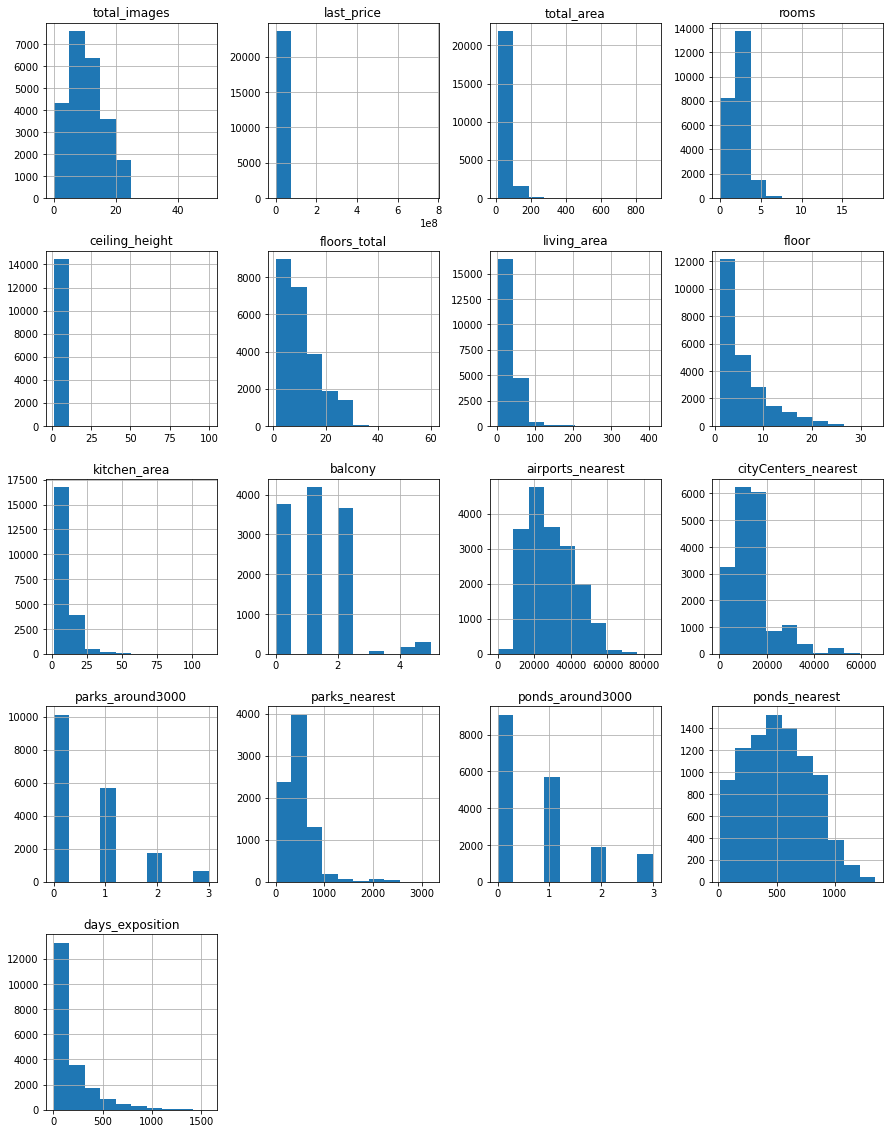

In [4]:
# построим гистограммы цифровых данных
raw_data.hist(figsize=(15, 20));

можем сразу отметить несколько распределений, выглядящих подозрительно (нужно будте изучить дополнительно):
- balcony (>4?)
- ceiling_height (высота потолков 100?)

## Предобработка данных

**Оценим каждую колоннку** 

In [5]:
# сделаем копию изначальных данных
data = raw_data.copy()

### Обработка данных колонки total_images

In [6]:
# total_images — число фотографий квартиры в объявлении
raw_data['total_images'].describe() 
# без явных отклонений 

count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

### Обработка данных колонки last price

In [7]:
# last_price — цена на момент снятия с публикации
(raw_data['last_price']/1000000).describe() # разделим на 1 млн для удобства визуализации


count    23699.000000
mean         6.541549
std         10.887013
min          0.012190
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

миниамльная стоимость квартиры 12 тысяч рублей выглядит подозрительно

In [8]:
# выведем информацию о квартире с минимльной ценой.
raw_data[raw_data['last_price'] == raw_data['last_price'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


2х комнатная квартира общей площадью 109 кв.м, при этом жилая 32 кв.м стоит всего 12 тыс.рублей.  Эти данные лучше убрать, поскольку ошибка и в цене и в площади.

In [9]:
# удалим строку с минимальным значением цены
data.drop(data[data['last_price'] == data['last_price'].min()].index, inplace=True)

In [10]:
# проверим текущие данные по мин. цене
data[data['last_price'] == data['last_price'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14911,5,430000.0,54.0,2018-06-26T00:00:00,2,NaN,3.0,NaN,3,NaN,...,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
17456,7,430000.0,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,NaN,...,6.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Обработка данных колонки total_area

In [11]:
# total_area — общая площадь объекта
raw_data['total_area'].describe() 

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [12]:
# проверим информацию о квартире с максимальной площадью
raw_data[raw_data['total_area'] == raw_data['total_area'].max()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25.0,409.7,25,NaN,...,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


12 комнатная квартира общей площадью 900 кв.м - похоже на правду

In [13]:
# проверим информацию о квартире с минимальной площадью
raw_data[raw_data['total_area'] == raw_data['total_area'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000.0,12.0,2017-07-19T00:00:00,1,2.55,5.0,10.0,2,NaN,...,NaN,NaN,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200.0


Тоже похожу на правду

### Обработка данных колонки first_day_exposition

first_day_exposition — дата публикации, имеет строковый тип данных (object), переведм в тип дата (datetime)

In [14]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)   

проверим изменения

In [15]:

data['first_day_exposition'].dtypes

dtype('<M8[ns]')

In [16]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

### Обработка данных колонки rooms

In [17]:
# rooms — количество комнат объекта
raw_data['rooms'].describe() 

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

выведем информацию о квартирах с минимальным количеством комнат

In [18]:

raw_data[raw_data['rooms'] == 0]['rooms'].count()

197

197 объектов имеет 0 комнат. Причиной ошибки скорее всего стал человеческий фактор и владельцы просто не внесли эти данные. Данные скорее всего придется заполнить средним значение из группы объектов с похожими значениями общей площади.

Выделим в данных группы по размерам общей площади. Ср.значение общей площади - 60 кв.м, ст.отклонение - 35,7 кв.м. Создадим следующие группы:
- до 25 кв.м (G)
- 26 - 45 кв.м (F)
- 46 - 65 кв.м (E)
- 66 - 105 кв.м (D)
- 106 - 205 кв.м (C)
- 206 - 305 кв.м (B)
- более 306 кв.м (A)

In [19]:
# функция категоризации по группам общей площади
def categorize_total_area(total_area):
    if total_area['total_area'] >= 306:
        return 'A'    
    if total_area['total_area'] >= 206:
        return 'B'    
    if total_area['total_area'] >= 106:
        return 'C'
    if total_area['total_area'] >= 66:
        return 'D'
    if total_area['total_area'] >= 46:
        return 'E'
    if total_area['total_area'] >= 26:
        return 'F'
    return 'G'

создамдим новую колоноку 'total_area_category' и разнесем данные

In [20]:

data['total_area_category'] = data.apply(categorize_total_area, axis=1)

посмотри как распределилось медианное количество комнат в каждой категории

In [21]:

data.pivot_table(index='total_area_category',values='rooms',aggfunc=['median','count'])

,median,count
,rooms,rooms
total_area_category,,
A,6,59
B,5,151
C,4,1383
D,3,5202
E,2,7456
F,1,9183
G,1,264


заменим 0 на NaN

In [22]:

data['rooms'].replace(0, np.nan, inplace=True)

заменим значения NaN на медианное значение количества комнат

In [23]:

data['rooms'] = data['rooms'].fillna(
    data['total_area_category'].map(
        data.groupby('total_area_category')['rooms'].median())
)

проверка наличия 0 комнат

In [24]:

data[data['rooms'] == 0]['rooms'].count()

0

приведем данные к целочисленному виду

In [25]:

data['rooms'] = data['rooms'].astype('int')

### Обработка данных колонки ceiling_height

In [26]:
# ceiling_height — высота потолков объекта
raw_data['ceiling_height'].describe() 

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Из 23699 строк данных только 14504 (чуть больше половины) содержат информацию о высоте потолка.

Также нужно проверить данные с высотой потолков более 5 и менее 2,4 метров

Так как большие дорогие квартиры могут иметь потолки и выше 5 метров, то мы ограничем размеры выборки общей плщощадью менее 100 кв.м

посмотрим сколько квартир имеет потолки более 5 метров и площадью более 100

In [27]:

data.query('ceiling_height >= 5 and total_area > 100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
464,15,66571000.0,280.3,2015-06-11,6,5.2,8.0,159.5,7,NaN,...,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0,B
1026,20,155000000.0,310.0,2018-10-12,5,5.3,3.0,190.0,3,NaN,...,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN,A
1388,20,59800000.0,399.0,2015-01-21,5,5.6,6.0,NaN,6,NaN,...,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0,A
7578,17,38000000.0,143.0,2017-11-02,3,5.5,5.0,83.0,5,NaN,...,1.0,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN,C
20264,17,119000000.0,187.6,2017-07-10,4,6.0,7.0,147.0,7,NaN,...,NaN,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0,C


Допустим такие, что такие квартиры могут обладать 5 метровыми потолками

посмотрим на данные квартир менее 100 кв.м и потолками более 5 м

In [28]:

data.query('ceiling_height >= 5 and total_area < 100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0,E
1053,13,550000.0,29.0,2018-02-01,1,5.0,3.0,NaN,1,False,...,NaN,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0,F
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0,F
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,NaN,...,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0,F
4876,7,3000000.0,25.0,2017-09-27,1,27.0,25.0,17.0,17,NaN,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0,G
5076,0,3850000.0,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,...,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0,F
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,NaN,...,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0,E
5669,4,4400000.0,50.0,2017-08-08,2,26.0,9.0,21.3,3,NaN,...,2.0,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0,E
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,NaN,...,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,D


Видим, что 32 строки содержат явные ошибки в высоте потолков. Скорее всего ошибки возникли из-за разницы размерности высоты: кто-то вносил в метрах, кто-то в сантиметрах. Поскольку данных о высоте потолков и так мало, попробуем не удалять, а внести исправления. Заменим подозрительные данные на значения NaN. 

удалим данные потолков выше 5 метров в квартирах общей площадью менее 100 кв.м

In [29]:

data.loc[(data.loc[:,'ceiling_height'] >= 5) & (data.loc[:,'total_area'] < 100), 'ceiling_height'] = np.nan

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

С решением согласен

Проверим тажке минимальную высоту потолков.
По СанПину высота потолков в квартире должна быть не менее 2,5 метров. С учетом наличия современных подвесных потолков, примем за отсечку в 2,4 метра.

посмотрим на данные с потолками менее 2.4 метра

In [30]:

data.query('ceiling_height < 2.4')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
227,13,2200000.0,47.00,2018-01-12,3,2.34,5.0,NaN,1,NaN,...,NaN,посёлок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,45.0,E
552,11,2999000.0,33.50,2017-03-30,1,2.00,15.0,17.500000,6,NaN,...,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0,F
1582,4,4100000.0,45.60,2016-01-13,2,2.30,9.0,28.400000,8,False,...,2.0,Санкт-Петербург,49152.0,14977.0,1.0,489.0,1.0,525.0,329.0,F
2572,4,2400000.0,62.00,2018-12-27,3,2.00,5.0,40.000000,4,NaN,...,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E
4212,1,2120000.0,35.43,2017-12-18,1,2.00,18.0,16.600000,9,NaN,...,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0,F
5498,17,2200000.0,56.00,2018-04-02,2,2.30,5.0,45.000000,1,NaN,...,2.0,Сясьстрой,NaN,NaN,NaN,NaN,NaN,NaN,55.0,E
5712,5,1500000.0,42.80,2017-08-14,2,1.20,2.0,27.500000,1,NaN,...,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0,F
5850,9,1650000.0,35.50,2018-05-29,1,2.00,5.0,NaN,5,NaN,...,NaN,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0,F
11352,4,3300000.0,36.00,2017-06-18,1,2.00,17.0,15.200000,12,NaN,...,0.0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0,F
12755,2,1400000.0,22.50,2017-09-21,1,2.20,2.0,18.000000,2,NaN,...,1.0,село Копорье,NaN,NaN,NaN,NaN,NaN,NaN,45.0,G


21 строки содержат подозрительно низкие высоты потолков. Скорее всего ошибки возникли из-за также из-за разницы размерности высоты: кто-то вносил в метрах, кто-то в сантиметрах. Поскольку данных о высоте потолков и так мало, попробуем не удалять, а внести исправления. Заменим подозрительные данные на значения NaN.

удалим данные с высотой потолков менее 2.4

In [31]:

data.loc[data.loc[:,'ceiling_height'] < 2.4, 'ceiling_height'] = np.nan

Заменим существующие и получившиеся пропуски на средние значениями высоты потолков из объектов той же категории общей площади.

заменим значения NaN на средние значения высота полотков для каждой категории общей площади

In [32]:

data['ceiling_height'] = data['ceiling_height'].fillna(
    data['total_area_category'].map(
        data.groupby('total_area_category')['ceiling_height'].mean().round(2))
)

проверим как выглядят обновленные данные

In [33]:

data['ceiling_height'].describe()

count    23698.000000
mean         2.721074
std          0.229556
min          2.400000
25%          2.600000
50%          2.670000
75%          2.800000
max          6.000000
Name: ceiling_height, dtype: float64

### Обработка данных колонки  floors_total

In [34]:
# floors_total — всего этажей в доме объекта
raw_data['floors_total'].describe() 

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [35]:
print('Количество данных с пропуском этажности дома:', data['floors_total'].isna().sum())

Количество данных с пропуском этажности дома: 86


Общая этажность дома влияет на стоимость квартиры. Но т.к. эти данные невозможно экстраполировать из других категорий, то придется пожертвовать 86 строками.

удалим 86 строк с пропуском этажности дома

In [36]:

data = data[data['floors_total'].notna()]
print('Количество данных с пропуском этажности дома:', data['floors_total'].isna().sum())

Количество данных с пропуском этажности дома: 0


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Верно, пропусков мало - можно удалить

приведем данные к целочисленному виду

In [37]:

data['floors_total'] = data['floors_total'].astype('int')

### Обработка данных колонки  living_area 

In [38]:
# living_area — жилая площадь объекта (т.е. площадь жилых помещений без площадей кухни, коридора и ванной)
raw_data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [39]:
print('Количество данных с пропусками в жилой площади дома:', data['living_area'].isna().sum())

Количество данных с пропусками в жилой площади дома: 1870


Данные с минимальной жилой площадью в 2 кв.м выглядят странно - проверим столбец подробнее.

посмотрим на распределение квартир по категориям общей площади с жилой площадью меньше 5 кв.м

In [40]:

data.query('living_area < 5').pivot_table(
    index='total_area_category', values=['total_area', 'living_area'], aggfunc=['mean','count'])

mean                  count           
                    living_area total_area living_area total_area
total_area_category                                              
C                           3.0      139.0           1          1
E                           2.0       52.0           1          1
F                           3.0       41.0           1          1
G                           2.0       23.0           1          1

Т.е. в данных есть 4 квартиры в разных категориях с подозрительно низкими значениями жилой площади. Возможно ошибки возникли в результате того, что пользователи неправильные вычесления, поскольку жилая площадь - это площадь без учета балконов, коридоров, сан.узлов и кухни, и  поэтому разница получилась ошибочно малой.

посмотрим на распределение квартир по категориям общей площади с жилой площадью больше 100 кв.м

In [41]:

data.query('living_area > 100').pivot_table(
    index='total_area_category', values=['total_area', 'living_area'], aggfunc=['mean','count'])

mean                   count           
                    living_area  total_area living_area total_area
total_area_category                                               
A                    230.602174  404.956522          46         46
B                    157.307000  245.177917         120        120
C                    115.926237  170.795161         186        186
D                    101.000000  102.700000           1          1

Будем считать, что данные с большими значениями жилой площади выглядят правдоподобно

Удалим данные c жилой площадью менее 5 кв.м. заменив на NaN

заменим данные жилой площади менее 5 кв.м на NaN

In [42]:

data.loc[data.loc[:,'living_area'] < 5, 'living_area'] = np.nan

Поскольку жилая площадь является уменьшенной общей площадью на определенный коэффициент, то попробуем вывести данный коэффициент для каждой категории квартир.

введем дополнительный коэффициент - соотношение общей и жилой площади и посмотрим на коэффициент

In [43]:

data = data.assign(total_to_living_area = lambda x: (x['total_area'] / x['living_area']))

data.pivot_table(index='total_area_category', values='total_to_living_area', aggfunc=['mean'])           

,mean
,total_to_living_area
total_area_category,
A,1.908185
B,1.722618
C,1.797734
D,1.747834
E,1.761175
F,1.975696
G,1.500423


Заполним значения NaN в столбце (k) отношение жилой к общей площади средним значением для объектов той же категории

заполним пропуски коэффициента средним значением из той же категории

In [44]:

data['total_to_living_area'] = data['total_to_living_area'].fillna(
    data['total_area_category'].map(
        data.groupby('total_area_category')['total_to_living_area'].mean().round(2))
)

Теперь заполним пропуски жилой площади

заполним пропуски жилой площади значением полученным делением жилой площади на k жилой площади

In [45]:

data['living_area'] = data['living_area'].fillna(
    round(data['total_area'] / data['total_to_living_area'],1)
)

посмотрим на исправленные данные

In [46]:

data['living_area'].describe()

count    23612.000000
mean        34.514385
std         22.290036
min          5.000000
25%         18.895000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

### Обработка данных колонки  floor

In [47]:
# floor — этаж на котором находится объект
raw_data['floor'].describe() 

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [48]:
# приведем данные к целочисленному виду
data['floor'] = data['floor'].astype('int')

### Обработка данных колонки  is_apartment 

In [49]:
# is_apartment — является ли объект апартаментами
print('Уникальные значения колонки:', raw_data['is_apartment'].unique())
print('Количество значений NaN:', raw_data['is_apartment'].isna().sum())
print('Количество значений True:', raw_data[raw_data['is_apartment'] == True]['is_apartment'].count())
print('Количество значений False:', raw_data[raw_data['is_apartment'] == False]['is_apartment'].count())


Уникальные значения колонки: [nan False True]
Количество значений NaN: 20924
Количество значений True: 50
Количество значений False: 2725


Поскольку апартаменты встречаются гораздо реже, то примем значения NaN за False

In [50]:
data['is_apartment'].fillna(value=False, inplace=True)
print('Уникальные значения колонки:', data['is_apartment'].unique())
print('Количество значений True:', data[data['is_apartment'] == True]['is_apartment'].count())
print('Количество значений False:', data[data['is_apartment'] == False]['is_apartment'].count())

Уникальные значения колонки: [False  True]
Количество значений True: 50
Количество значений False: 23562


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Верно, ведь это булевый столбец

### Обработка данных колонки  studio 

In [51]:
# studio — является ли объект квартирой-студией
print('Уникальные значения колонки:', raw_data['studio'].unique())
print('Количество значений True:', raw_data[raw_data['studio'] == True]['studio'].count())
print('Количество значений False:', raw_data[raw_data['studio'] == False]['studio'].count())

Уникальные значения колонки: [False  True]
Количество значений True: 149
Количество значений False: 23550


### Обработка данных колонки  open_plan 

In [52]:
# open_plan — имеет ли объект свободную планировку
print('Уникальные значения колонки:', raw_data['open_plan'].unique())
print('Количество значений True:', raw_data[raw_data['open_plan'] == True]['open_plan'].count())
print('Количество значений False:', raw_data[raw_data['open_plan'] == False]['open_plan'].count())

Уникальные значения колонки: [False  True]
Количество значений True: 67
Количество значений False: 23632


### Обработка данных колонки kitchen_area 

In [53]:
# kitchen_area — площадь кухни в квадратных метрах (м²)
raw_data['kitchen_area'].describe() 

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

количество пропусков

In [54]:

data['kitchen_area'].isna().sum() 

2231

Исследуем данные о площади кухни

Согласно СанПин нормам минимальная кухня-купе может быть 5 кв.м

посмотрим на кухни с площадью менее 5 кв.м 

In [55]:

data.query('kitchen_area < 5').pivot_table(index='total_area_category', values='kitchen_area', aggfunc=['mean','count'])

,mean,count
,kitchen_area,kitchen_area
total_area_category,,
D,2.890000,1
E,4.405000,20
F,4.103175,63
G,3.330000,20


Возможно ошибки возникли в результате того, что пользователи вместо площади указали ширину кухни.

Заполним ошибки тем же способом, что и жилую площадь. Заменим ошибочные данные с площадью кухни на NaN, введем коэффициент отношения общей площади к площади кухни, заполним значения NaN результатом деления общей площади на коэффициент.
заменим данные площади кухни менее 5 кв.м на NaN

In [56]:

data.loc[data.loc[:,'kitchen_area'] < 5, 'kitchen_area'] = np.nan

введем дополнительный коэффициент - соотношение общей площади к площади кухни, заполним пропуски коэффициента средним значением из той же категории, заполним пропуски площади кухни значением полученным делением жилой площади на k кухни

In [57]:

data = data.assign(total_to_kitchen_area = lambda x: (x['total_area'] / x['kitchen_area']))


data['total_to_kitchen_area'] = data['total_to_kitchen_area'].fillna(
    data['total_area_category'].map(
        data.groupby('total_area_category')['total_to_kitchen_area'].mean().round(2))
)


data['kitchen_area'] = data['kitchen_area'].fillna(
    round(data['total_area'] / data['total_to_kitchen_area'],1)
) 

проверим как изменились данные 

In [58]:

data['kitchen_area'].describe() 

count    23612.000000
mean        10.432957
std          5.721913
min          3.100000
25%          7.000000
50%          9.000000
75%         11.780000
max        112.000000
Name: kitchen_area, dtype: float64

### Обработка данных колонки balcony

In [59]:
#balcony — число балконов
raw_data['balcony'].describe()

count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

посмотрим уникальные значения колонки

In [60]:

data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

заменим NaN на число 0

In [61]:

data['balcony'].fillna(value=0, inplace=True)

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Согласен, если пропуск - вероятнее всего балкон отсутствует

изменим категорию данных на int поскольку число балковнов может быть только целым

In [62]:

data['balcony'] = data['balcony'].astype('int')

проверим категорию

In [63]:

data['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

Квартиры с числом болканов больше 2 выглядят подозрительно. Если в квартире не более 2ух комнат, наличие 4 балконов и более - явная ошибка, кухня и две комнаты дают возможность только для 3 балконов. Возможно ошибки вызваны, тем что пользователи заполнили площадь балкона, вместо количества.

заменим в квартирах менее 100 кв.м с количеством комнат 2 и менее число балконов 3 и более на 1

In [64]:

data.loc[(data.loc[:,'balcony'] > 3) & (data.loc[:,'rooms'] <= 2) & (data.loc[:,'total_area'] < 100), 'balcony'] = 1

### Обработка данных колонки locality_name

In [65]:
#locality_name — название населённого пункта
print('Количество уникльных населенных пунктов', raw_data['locality_name'].nunique())
data['locality_name'].sort_values().unique()

Количество уникльных населенных пунктов 364


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

удалим из названия тип поселения 

In [66]:

data['locality_name'] = data['locality_name'].str.replace('ё','е', regex=True)
data['locality_name'] = data['locality_name'].str.replace('городской ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('коттеджный ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('поселок ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('городского типа ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('городского типа ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('деревня ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('село ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('имени ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной станции ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество ','', regex=True)
data['locality_name'] = data['locality_name'].str.replace('станции ','', regex=True)

посмотрим на изменения

In [67]:

data['locality_name'].sort_values().unique()

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жилгородок', 'Жилпоселок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Извара'

количество уникальных значений после обработки уменьшилось на 59 значений

In [68]:

data['locality_name'].nunique()

305

количество пропусков данных в названиях

In [69]:

data['locality_name'].isna().sum()

48

так как данные о населенном пункте невозможно экстраполировать, то эти данные придется удалить 

In [70]:

data.dropna(subset = ['locality_name'], inplace=True)

### Обработка данных колонки airports_nearest

In [71]:
#airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
raw_data['airports_nearest'].describe() 

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

количество пропусков

In [72]:

data['airports_nearest'].isna().sum()

5524

Пропуски могли образоваться из-за ошибок в геосервисах.

посмотрим на данные с min расстоянием до аэропорта

In [73]:

data.query('airports_nearest == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,total_to_living_area,total_to_kitchen_area
21085,0,7000000.0,34.7,2018-09-23,1,2.7,9,19.8,3,False,...,0.0,22801.0,0.0,NaN,0.0,NaN,60.0,F,1.752525,5.783333


расстояние до аэропорта 0 быть не может, поэтому заменим на NaN

In [74]:
data['airports_nearest'].replace(0, np.nan, inplace=True)

Заполним пропуски средним значением расстояния до аэропорта для каждой категории

Посмотрим на средние значения до аэропорта в разбивки по категориям.

In [75]:

data.pivot_table(index='total_area_category', values='airports_nearest', aggfunc=['mean','count'])

,mean,count
,airports_nearest,airports_nearest
total_area_category,,
A,27422.727273,55
B,25875.578231,147
C,27972.854310,1311
D,28660.637275,4287
E,28793.226920,5535
F,29258.715481,6576
G,22370.312500,128


как видим данные не сильно различаются от категории к категории, поэтому заполним пропущенные данные средним значением

In [76]:

data['airports_nearest'].fillna(value=round(data['airports_nearest'].mean(),0), inplace=True)

### Обработка данных колонки cityCenters_nearest

In [77]:
#cityCenters_nearest — расстояние до центра города (м)
raw_data['cityCenters_nearest'].describe() 

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

посмотрим сколько пропусков в данной колонке

In [78]:

data['cityCenters_nearest'].isna().sum()

5501

посмотрим на средние значения до центра в разбивки по категориям

In [79]:

data.pivot_table(index='total_area_category', values='cityCenters_nearest', aggfunc=['mean','count'])

,mean,count
,cityCenters_nearest,cityCenters_nearest
total_area_category,,
A,8236.701754,57
B,6461.344595,148
C,8516.273004,1315
D,12652.048684,4293
E,14956.497745,5543
F,15956.561332,6579
G,12070.031250,128


заполним средними значениями в зависимости от категории квартиры

In [80]:

data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(round(
    data['total_area_category'].map(data.groupby('total_area_category')['cityCenters_nearest'].mean()),0)
)

### Обработка данных колонки parks_around3000

In [81]:
#parks_around3000 — число парков в радиусе 3 км
raw_data['parks_around3000'].describe() 

count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

количество пропусков в колонке

In [82]:

data['parks_around3000'].isna().sum()

5500

Поскольку данные были взяты из гео-программ, возможно, какие-то ошибки в алгоритмах расчета.

самое частое значение в колонке

In [83]:

data['parks_around3000'].mode()

0    0.0
dtype: float64

заполним пропуски самым частым значением

In [84]:

data['parks_around3000'].fillna(value=0, inplace=True)

заменим категорию данных на int поскольку количество парков может быть только целым

In [85]:

data['parks_around3000'] = data['parks_around3000'].astype('int')

проверим категорию

In [86]:

data['parks_around3000'].unique()

array([1, 0, 2, 3])

проверим нет ли объектов, у которых расстояние до парка менее 3 км, но не проставлено количество парков в зоне досягаемости

In [87]:

data.query('parks_around3000 == 0 and parks_nearest <= 3000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,total_to_living_area,total_to_kitchen_area


проверим нет ли объектов, у которых проставлено количество парков в зоне досягаемости, но не проставлено расстояние

In [88]:

data.query('parks_around3000 != 0 and parks_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,total_to_living_area,total_to_kitchen_area


посмотрим на распределение парков

In [89]:

data.pivot_table(index='parks_around3000', values='parks_nearest', aggfunc=['count'])

,count
,parks_nearest
parks_around3000,
0,4
1,5646
2,1736
3,643


т.е. у нас только 4 объекта имеют проставленное расстояние за пределами 3 км зоны.

### Обработка данных колонки parks_nearest  

In [90]:
#parks_nearest — расстояние до ближайшего парка (м)
raw_data['parks_nearest'].describe() 

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

посмотрим на пропуски

In [91]:

data['parks_nearest'].isna().sum()

15535

заполним пропуски средним расстоянием парков за пределами 3 км зоны досягаемости

In [92]:

data['parks_nearest'] = data['parks_nearest'].\
fillna(round(data.query('parks_nearest > 3000')['parks_nearest'].mean(),0))

посмотрим на медианные расстояния до парков в зависимости от их наличия в зоне 3000м

In [93]:

data.pivot_table(index='parks_around3000', values='parks_nearest', aggfunc=['median','count'])

,median,count
,parks_nearest,parks_nearest
parks_around3000,,
0,3114.0,15539
1,501.0,5646
2,366.0,1736
3,307.0,643


### Обработка данных колонки ponds_around3000

In [94]:
#ponds_around3000 — число водоёмов в радиусе 3 км
raw_data['ponds_around3000'].describe() 

count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

количество пропусков в колонке

In [95]:

data['ponds_around3000'].isna().sum()

5500

Заполним пропуски самым частым значением

самое частое значение в колонке

In [96]:

data['ponds_around3000'].mode()

0    0.0
dtype: float64

заполним пропуски самым частым значением

In [97]:

data['ponds_around3000'].fillna(value=0, inplace=True)

заменим категорию данных на int

In [98]:

data['ponds_around3000'] = data['parks_around3000'].astype('int')

проверим категорию

In [99]:

data['ponds_around3000'].unique()

array([1, 0, 2, 3])

проверим нет ли объектов, у которых расстояние до воды менее 3 км, но не проставлено количество водоемов в зоне досягаемости

In [100]:

data.query('ponds_around3000 == 0 and ponds_nearest < 3000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,total_to_living_area,total_to_kitchen_area
14,1,4400000.0,36.0,2016-06-23,1,2.63,6,17.0,1,False,...,20782.0,30759.0,0,3114.0,0,96.0,203.0,F,2.117647,4.500000
17,6,4180000.0,36.0,2016-09-09,1,2.63,17,16.5,7,False,...,33564.0,14616.0,0,3114.0,0,859.0,571.0,F,2.181818,3.272727
25,3,6800000.0,76.0,2015-10-01,2,2.75,23,39.0,18,False,...,34967.0,14640.0,0,3114.0,0,564.0,300.0,D,1.948718,5.066667
26,6,4050000.0,60.0,2017-04-28,4,2.67,5,43.0,4,False,...,11580.0,10510.0,0,3114.0,0,95.0,265.0,E,1.395349,8.571429
28,8,4170000.0,44.0,2017-12-13,1,2.90,6,20.8,1,False,...,18557.0,30710.0,0,3114.0,0,118.0,74.0,F,2.115385,3.760684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23667,14,9990000.0,90.0,2017-01-23,3,3.06,17,55.0,9,False,...,56343.0,33272.0,0,3114.0,0,545.0,86.0,D,1.636364,8.181818
23669,8,3000000.0,34.1,2017-11-10,1,2.63,9,17.0,3,False,...,24687.0,30473.0,0,3114.0,0,741.0,74.0,F,2.005882,3.788889
23674,10,5950000.0,56.0,2019-03-05,3,2.67,8,32.1,3,False,...,32139.0,9217.0,0,3114.0,0,303.0,NaN,E,1.744548,6.588235
23678,10,3500000.0,43.0,2016-05-19,2,2.50,3,26.1,2,False,...,15823.0,27977.0,0,3114.0,0,1134.0,252.0,F,1.647510,4.810000


4249 объекта с расстоянием менее 3 км до водоема. Значит нужно проставить хоят бы 1 водоем в наличии.

исправим данные в колоноке ponds_nearest заменив 0 на хотя бы 1 водоем, если досягаемость менее или равна 3000 м

In [101]:

data.loc[(data.loc[:,'ponds_around3000'] == 0) & (data.loc[:,'ponds_nearest'] <= 3000), 'ponds_around3000'] = 1

### Обработка данных колонки ponds_nearest

In [102]:
#ponds_nearest — расстояние до ближайшего водоёма (м)
raw_data['ponds_nearest'].describe() 

count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

посмотрим на пропуски

In [103]:

data['ponds_nearest'].isna().sum()

14528

посмотрим на распределение данных о расстояниях до водоема

In [104]:

data.pivot_table(index='ponds_around3000', values='ponds_nearest', aggfunc=['median','count'])

,median,count
,ponds_nearest,ponds_nearest
ponds_around3000,,
0,NaN,0
1,528.0,7390
2,410.0,1116
3,379.0,530


Т.к. у нас нет данных об объектах за пределами 3 км зоны, то заполним отсутствующие значение любым расстоянием большим 3 км. Например, возьмем цифру в 5000 м

заполним пропуски расстоянием за пределами 3 км зоны досягаемости, например в 5000м

In [105]:

data['ponds_nearest'] = data['ponds_nearest'].fillna(5000)

 проверим получившиеся данные

In [106]:

data.pivot_table(index='ponds_around3000', values='ponds_nearest', aggfunc=['median','count'])

,median,count
,ponds_nearest,ponds_nearest
ponds_around3000,,
0,5000.0,11290
1,668.0,9895
2,671.5,1736
3,440.0,643


### Обработка данных колонки days_exposition

In [107]:
# days_exposition — сколько дней было размещено объявление (от публикации до снятия)
raw_data['days_exposition'].describe() 

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

 количество пропусков

In [108]:

data['days_exposition'].isna().sum()

3171

Будем считать, что пропуски означают, что квартира еще продается. Тогда чтобы заполнить пропуски, нужно определить дату загрузки данных и посчитать разницу между этим днем и днем экспозиции

определим максимальную дату первого дня экспозиции - это и будет день загрузки данных

In [109]:

data[data['first_day_exposition'] == data['first_day_exposition'].max()] 


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category,total_to_living_area,total_to_kitchen_area
2178,10,5100000.0,51.00,2019-05-03,1,2.67,9,15.00,2,False,...,28798.0,14956.0,0,3114.0,0,5000.0,NaN,E,3.400000,2.040000
3254,16,8800000.0,80.00,2019-05-03,3,2.80,17,31.00,15,False,...,28798.0,12652.0,0,3114.0,0,5000.0,NaN,D,2.580645,2.962963
4450,13,3500000.0,34.60,2019-05-03,1,2.50,5,19.40,3,False,...,13107.0,25261.0,1,361.0,1,5000.0,NaN,F,1.783505,4.739726
5986,0,5000000.0,48.00,2019-05-03,3,2.50,9,27.30,2,False,...,51060.0,16892.0,0,3114.0,0,5000.0,NaN,E,1.760000,6.550000
8170,4,3280000.0,38.19,2019-05-03,1,2.63,6,14.41,4,False,...,28798.0,15957.0,0,3114.0,0,5000.0,NaN,F,2.650243,3.722222
9217,7,4300000.0,35.70,2019-05-03,1,2.70,21,15.00,12,False,...,28798.0,15957.0,0,3114.0,0,5000.0,NaN,F,2.380000,2.746154
10917,20,10000000.0,62.30,2019-05-03,2,2.67,6,20.00,3,False,...,25083.0,3148.0,2,629.0,2,5000.0,NaN,E,3.115000,2.076667
12003,10,950000.0,37.10,2019-05-03,1,2.63,4,17.00,4,False,...,28798.0,15957.0,0,3114.0,0,5000.0,NaN,F,2.182353,4.416667
12208,7,9000000.0,60.30,2019-05-03,2,3.25,5,36.90,4,False,...,32302.0,4662.0,1,398.0,1,5000.0,NaN,E,1.634146,10.396552
12343,12,2890000.0,48.80,2019-05-03,2,2.55,5,29.40,1,False,...,28798.0,14956.0,0,3114.0,0,5000.0,NaN,E,1.659864,6.777778


2019-05-03

добавим колонку с датой загрузки данных current_day_exposition

In [110]:

data['current_day_exposition'] = data.loc[2178,'first_day_exposition']

посчитаем разницу между датой размещения и датой загрузки данных, добавим в колонку days_exposition_to_current

In [111]:

data['days_exposition_to_current'] = (data['current_day_exposition'] - data['first_day_exposition']).dt.days

заполним пропуски получившейся разницей

In [112]:

data['days_exposition'].fillna(data['days_exposition_to_current'], inplace=True)

преведем длительность экспозиции к целочисленному типу

In [113]:

data['days_exposition'] = data['days_exposition'].astype(int)

### ПРОВЕРКА

проверим пропуски

In [114]:

for i in data.columns:
    print(f'Количество пропусков в колонке {i} равно {data[i].isna().sum()}')

Количество пропусков в колонке total_images равно 0
Количество пропусков в колонке last_price равно 0
Количество пропусков в колонке total_area равно 0
Количество пропусков в колонке first_day_exposition равно 0
Количество пропусков в колонке rooms равно 0
Количество пропусков в колонке ceiling_height равно 0
Количество пропусков в колонке floors_total равно 0
Количество пропусков в колонке living_area равно 0
Количество пропусков в колонке floor равно 0
Количество пропусков в колонке is_apartment равно 0
Количество пропусков в колонке studio равно 0
Количество пропусков в колонке open_plan равно 0
Количество пропусков в колонке kitchen_area равно 0
Количество пропусков в колонке balcony равно 0
Количество пропусков в колонке locality_name равно 0
Количество пропусков в колонке airports_nearest равно 0
Количество пропусков в колонке cityCenters_nearest равно 0
Количество пропусков в колонке parks_around3000 равно 0
Количество пропусков в колонке parks_nearest равно 0
Количество пропуск

удалим вспомогательные колоноки

In [115]:

data.drop(
    ['total_area_category', 'total_to_living_area',
            'total_to_kitchen_area', 'current_day_exposition',
            'days_exposition_to_current'], axis=1, inplace=True
)

оценим количество удаленных данных

In [116]:

print(f'Удалено {len(raw_data) - len(data)} строк')
print(f'{round((len(raw_data) - len(data))/len(raw_data), 3)*100} % от изначальных данных')

Удалено 135 строк
0.6 % от изначальных данных


проверим полные дубликаты

In [117]:
data.duplicated().sum()

0

<b>
    Качество исходных данных

Исходные данные содержат достаточное количество ошибок, которых можно было бы избежать еще на этапе сбора. 
Например
- `ceiling_height` — высота потолков. Обязть заполнять данные в см: заполнить 3 цифры без запятой
- `rooms`, `balcony`, `floors` —  Не публиковать объявление пока не будут заполнены обязательные разделы
- `locality_name` — название населённого пункта. Сделать отдельную колонку тип населенного пункта

- проверить работы алгоритмов геосервисов для расчета расстояний до объекта


## Новые столбцы

### цена одного квадратного метра

In [118]:
#цена одного квадратного метра (значение до двух знаков после запятой)
data = data.assign(price_per_sq_m = lambda x: round((x['last_price'] / x['total_area']),2))

### день недели публикации

In [119]:
# день недели публикации
data = data.assign(weekday_exposition = lambda x: x['first_day_exposition'].dt.weekday)

### месяц публикации

In [120]:
# месяц публикации
data = data.assign(month_exposition = lambda x: x['first_day_exposition'].dt.month)

### год публикации

In [121]:
# год публикации
data = data.assign(year_exposition = lambda x: x['first_day_exposition'].dt.year)

### категория этажа

создадим функцию категоризации по уровню этажа

In [122]:
def floor_category_definder(floor):
    if floor['floor'] == floor['floors_total']:
        return 'последний'    
    if floor['floor'] == 1:
        return 'первый'    
    return 'другой'

создадим новую колонку с категорией этажа

In [123]:
data['floor_category'] = data.apply(floor_category_definder, axis=1)

In [124]:
data['floor_category'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

### расстояние до центра в км

In [125]:
# расстояние до центра в км
data = data.assign(city_centre_distance_km = lambda x: round((x['cityCenters_nearest']/1000),0))

In [126]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_m,weekday_exposition,month_exposition,year_exposition,floor_category,city_centre_distance_km
0,20,13000000.0,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,482.0,1,755.0,57,120370.37,3,3,2019,другой,16.0


## Исследовательский анализ данных

### Изучить и описать параметры

#### Общая площадь объекта

In [127]:
# Количество уникальных значений общей площади
data['total_area'].nunique()

2159

создадим функцию для описания данных в колонке

In [128]:

def describ_function(data,i,j):
    print(f"{j} максимальное значение {data[i].describe()['max']:.0f}")
    print(f"{j} минимальное значение {data[i].describe()['min']:.0f}")
    print(f"{j} среднее значение {data[i].describe()['mean']:.0f}")
    print(f"{j} самое частое значение {data[i].mode()[0]:.0f}")

In [129]:
describ_function(data, 'total_area', 'Общая площадь')

Общая площадь максимальное значение 900
Общая площадь минимальное значение 12
Общая площадь среднее значение 60
Общая площадь самое частое значение 45


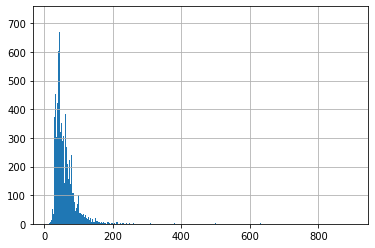

In [130]:
data['total_area'].hist(bins=1000);

Гистограмма, на мой взгляд, не очень наглядно передает распределение. Построим другой график.

создадим функцию для построения графика наиболее часто встречающихся значений

In [131]:

def chart_function (data, i, j, k, l, width):
    plt.bar(data.groupby(
        i)[i].count().index, data.groupby(
        i)[i].count().values,  width=width)
    plt.xlabel(j)
    plt.ylabel('Частота встречаемости')
    plt.title(f'{j} распределение наиболее частых значений')
    plt.axis([0, k, 0, l])


построим график наиболее часто встречающихся значений обще площади

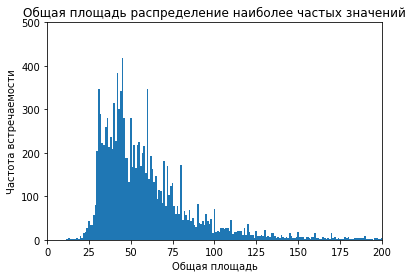

In [132]:

chart_function(data, 'total_area', 'Общая площадь', 200, 500, 1)

#### Жилая площадь объекта

Количество уникальных значений 1816
Жилая площадь максимальное значение 410
Жилая площадь минимальное значение 5
Жилая площадь среднее значение 35
Жилая площадь самое частое значение 18


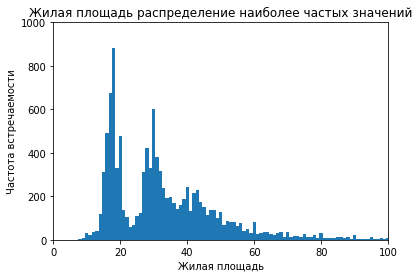

In [133]:
print('Количество уникальных значений',data['living_area'].nunique())
chart_function(data, 'living_area', 'Жилая площадь', 100, 1000, 1)
describ_function(data, 'living_area', 'Жилая площадь')

#### Площадь кухни объекта

Количество уникальных значений 956
Площадь кухни максимальное значение 112
Площадь кухни минимальное значение 3
Площадь кухни среднее значение 10
Площадь кухни самое частое значение 6


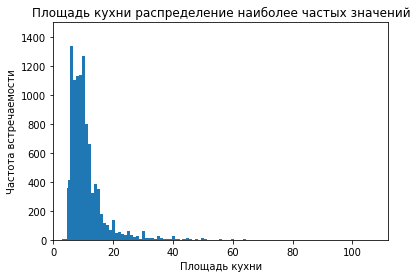

In [134]:
print('Количество уникальных значений',data['kitchen_area'].nunique())
chart_function(data, 'kitchen_area', 'Площадь кухни', 112, 1500,1)
describ_function(data, 'kitchen_area', 'Площадь кухни')

#### Количество комнат объекта

Количество уникальных значений 16
Количество комнат максимальное значение 19
Количество комнат минимальное значение 1
Количество комнат среднее значение 2
Количество комнат самое частое значение 1


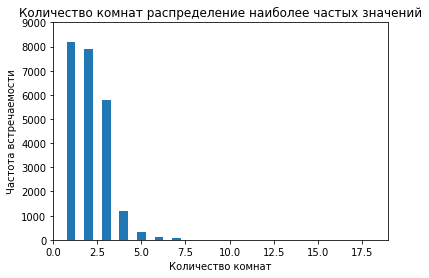

In [135]:
print('Количество уникальных значений',data['rooms'].nunique())
chart_function(data, 'rooms', 'Количество комнат', 19, 9000, 0.5)
describ_function(data, 'rooms', 'Количество комнат')

#### Высота потолков

Количество уникальных значений 160
Высота потолков максимальное значение 6.0
Высота потолков минимальное значение 2.4
Высота потолков среднее значение 2.7
Высота потолков самое частое значение 2.6


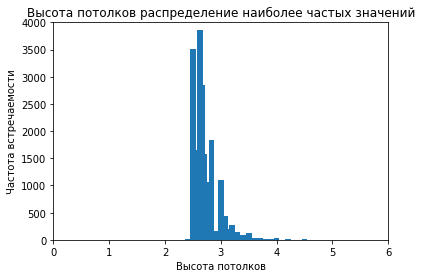

In [136]:
print('Количество уникальных значений',data['ceiling_height'].nunique())
chart_function(data, 'ceiling_height', 'Высота потолков', 6, 4000, 0.1)
i,j = ['ceiling_height', 'Высота потолков']
print(f"{j} максимальное значение {data[i].describe()['max']:.1f}")
print(f"{j} минимальное значение {data[i].describe()['min']:.1f}")
print(f"{j} среднее значение {data[i].describe()['mean']:.1f}")
print(f"{j} самое частое значение {data[i].mode()[0]:.1f}")

#### Количество этажей объекта

Количество уникальных значений 36
Общее количество этажей максимальное значение 60
Общее количество этажей минимальное значение 1
Общее количество этажей среднее значение 11
Общее количество этажей самое частое значение 5


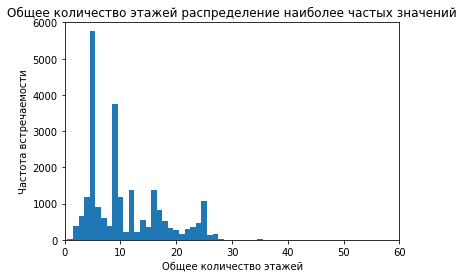

In [137]:
print('Количество уникальных значений',data['floors_total'].nunique())
chart_function(data, 'floors_total', 'Общее количество этажей', 60, 6000,1)
describ_function(data, 'floors_total', 'Общее количество этажей')

#### Расстояние до центра города

Количество уникальных значений 7627
Расстояние до центра города максимальное значение 65968
Расстояние до центра города минимальное значение 181
Расстояние до центра города среднее значение 14363
Расстояние до центра города самое частое значение 15957


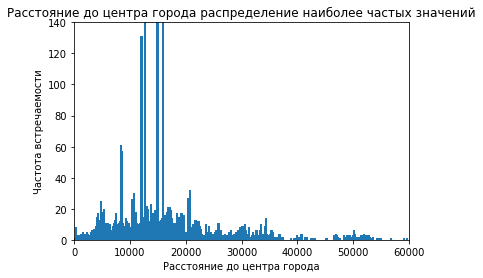

In [138]:
print('Количество уникальных значений',data['cityCenters_nearest'].nunique())
describ_function(data, 'cityCenters_nearest', 'Расстояние до центра города')
chart_function(data, 'cityCenters_nearest', 'Расстояние до центра города', 60000, 140, 400)

#### Расстояние до ближайшего парка

Количество уникальных значений 995
Расстояние до ближайшего парка максимальное значение 3190
Расстояние до ближайшего парка минимальное значение 1
Расстояние до ближайшего парка среднее значение 2220
Расстояние до ближайшего парка самое частое значение 3114


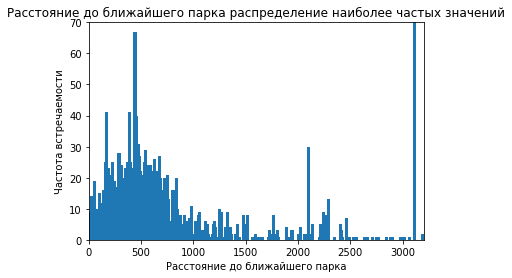

In [139]:
print('Количество уникальных значений',data['parks_nearest'].nunique())
describ_function(data, 'parks_nearest', 'Расстояние до ближайшего парка')
chart_function(data, 'parks_nearest', 'Расстояние до ближайшего парка', 3200, 70,30)

#### Тип этажа квартиры

In [140]:
print('Количество объектов на первом этаже:',data[data['floor_category'] == 'первый']['floor_category'].count())
print('Количество объектов на последнем этаже:',data[data['floor_category'] == 'последний']['floor_category'].count())
print('Количество объектов ни на первом, ни на последнем этаже:', 
      data[data['floor_category'] == 'другой']['floor_category'].count())

Количество объектов на первом этаже: 2884
Количество объектов на последнем этаже: 3354
Количество объектов ни на первом, ни на последнем этаже: 17326


<AxesSubplot:>

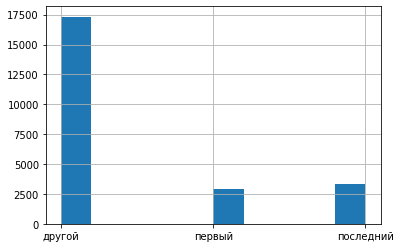

In [141]:
data['floor_category'].hist()

#### Цена объекта

Количество уникальных значений 2924
Цена объекта максимальное значение 763000000
Цена объекта минимальное значение 430000
Цена объекта среднее значение 6540335
Цена объекта самое частое значение 4500000


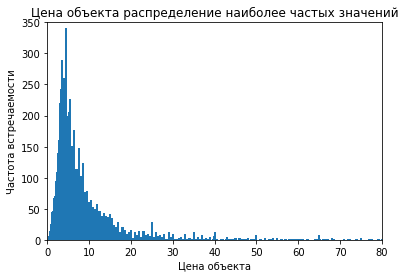

In [142]:
print('Количество уникальных значений',data['last_price'].nunique())
describ_function(data, 'last_price', 'Цена объекта')

# уберем на графике лишние 0 для лучшего отображения (1 млн)
i,j,k,l,w = ['last_price', 'Цена объекта', 80, 350, 0.5]
plt.bar(data.groupby(i)[i].count().index/1000000, data.groupby(i)[i].count().values,  width=w)
plt.xlabel(j)
plt.ylabel('Частота встречаемости')
plt.title(f'{j} распределение наиболее частых значений')
plt.axis([0, k, 0, l])
plt.show()

### Изучить, как быстро продавались квартиры

#### гистограмма сроков продажи

выделим данные без 0, т.е. те квартиры, которые уже продались

In [143]:

df_sales_time = data.query('days_exposition != 0')

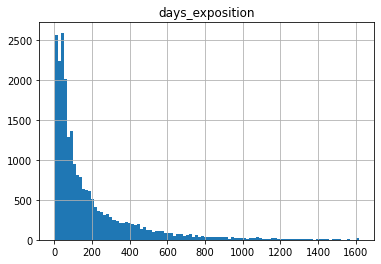

In [144]:
df_sales_time.hist('days_exposition', bins=100);

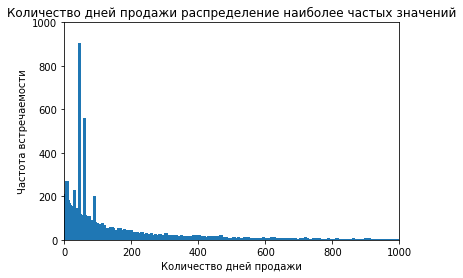

In [145]:
chart_function(df_sales_time, 'days_exposition', 'Количество дней продажи', 1000, 1000, 10)

#### cреднее и медианное значения сроков продажи

In [146]:

print(f"Количество дней продажи среднее значение \
{df_sales_time['days_exposition'].mean():.0f}")
print(f"Количество дней продажи медианное значение \
{df_sales_time['days_exposition'].median():.0f}")

Количество дней продажи среднее значение 186
Количество дней продажи медианное значение 94


#### cколько обычно занимает продажа

Среднее значение дней продажи 186 дней, но поскольку у нас смещенное распределение, то
для оценки среднего значения лучше взять медиану - 94 дня.
Однако, медиана не полностью отражает ориентировочный срок продажи. Для более наглядного представления возьмем межквартильный размах.

In [147]:

q25 = df_sales_time['days_exposition'].quantile(0.25)
q75 = df_sales_time['days_exposition'].quantile(0.75)
num_in_iqr = df_sales_time[(df_sales_time['days_exposition'] > q25) & (
    df_sales_time['days_exposition'] < q75)]['days_exposition'].count()

print(f'Первый квартиль {q25:.0f} дня')
print(f'Третий квартиль {q75:.0f} дня')
print(f'Количество значений в IQR {num_in_iqr}')
print(f'Процент значений в IQR {num_in_iqr/len(df_sales_time):.0%}')


Первый квартиль 43 дня
Третий квартиль 237 дня
Количество значений в IQR 11692
Процент значений в IQR 50%


Аномальными значениями дней продаж (слишком быстрыми, либо долгими) будем считать значения за пределами доверительного интервала 0.95

In [148]:
# 1+-alpha/2
print(f"Необчно быстрые продажи менее \
{df_sales_time['days_exposition'].quantile(q=0.025):.0f} дней")
print(f"Необчно долгие продажи более \
{df_sales_time['days_exposition'].quantile(q=0.975):.0f} дней")

Необчно быстрые продажи менее 5 дней
Необчно долгие продажи более 884 дней


Можем также создать таблицу топ-10 наиболее частых значений сроков продаж

In [149]:

df = data.pivot_table(
    index='days_exposition', values='first_day_exposition', aggfunc=['count'])\
.sort_values(('count','first_day_exposition'), ascending=False).iloc[:10]

df['percentage'] = round(df['count']['first_day_exposition'] *100 / len(data), 1)
df

,count,percentage
,first_day_exposition,
days_exposition,,
45,907,3.8
60,559,2.4
7,269,1.1
30,230,1.0
4,210,0.9
90,200,0.8
3,182,0.8
11,181,0.8


Из получившейся таблицы можем выделить несколько "рубежных" значений сроков продаж:
- быстрые (3,4,5 дней)
- неделя (7,9,11 дней)
- месяц 
- 1,5 месяца
- 2 месяца
- 3 месяца

 ### Факторы влияющие на общую стоимость объекта

 #### Влияние площадей и количества комнат объекта на цену

построим матрицу корреляции для цены, значений площадей и количества комнат объекта

In [150]:
from scipy import stats

PearsonRResult(statistic=0.6536868722597048, pvalue=0.0)


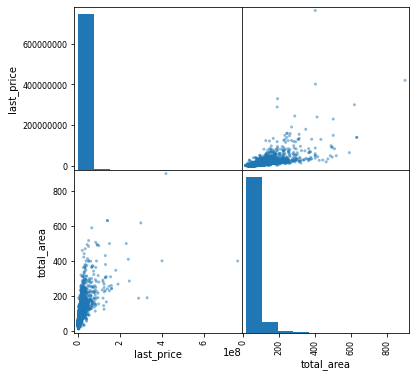

In [151]:
pd.plotting.scatter_matrix(data[['last_price','total_area']], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['total_area']))

Умеренная прямая зависимость между ценой объекта и общей площадью

PearsonRResult(statistic=0.5853813959291362, pvalue=0.0)


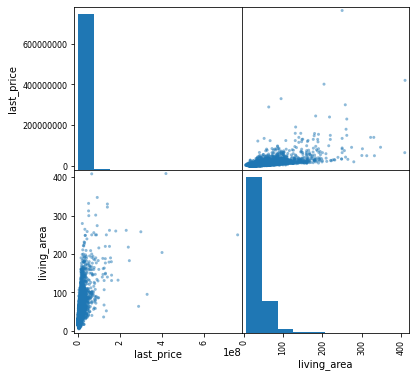

In [152]:
pd.plotting.scatter_matrix(data[['last_price','living_area']], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['living_area']))

Умеренная прямая зависимость между ценой объекта и жилой площадью

PearsonRResult(statistic=0.4800020521087728, pvalue=0.0)


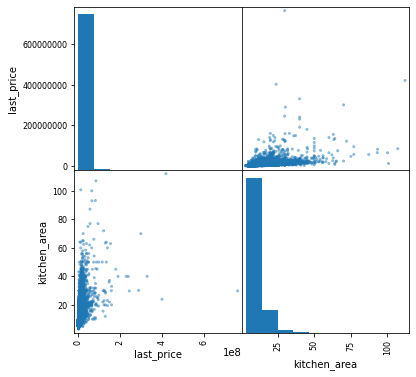

In [153]:
pd.plotting.scatter_matrix(data[['last_price','kitchen_area']], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['kitchen_area']))

PearsonRResult(statistic=0.3662350931047065, pvalue=0.0)


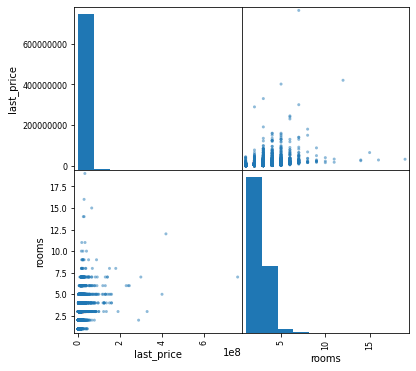

In [154]:
pd.plotting.scatter_matrix(data[['last_price','rooms']], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['rooms']))

Умеренная прямая зависимость между ценой объекта и количеством комнат

PearsonRResult(statistic=0.0013488784604988842, pvalue=0.8359710892150503)


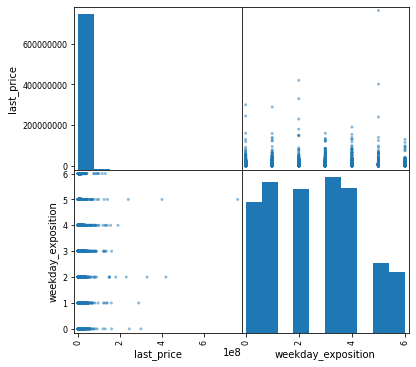

In [155]:
pd.plotting.scatter_matrix(data[['last_price','weekday_exposition']], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['weekday_exposition']))

Корреляция между ценой и значениями деня недели отсутствует

PearsonRResult(statistic=0.002701305343786045, pvalue=0.678402146676475)


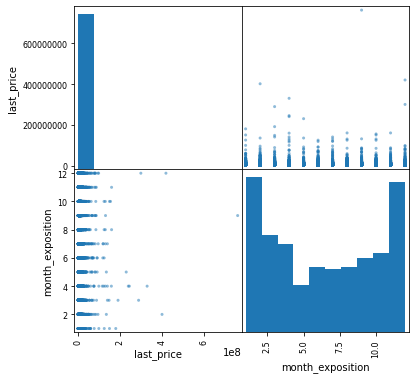

In [156]:
pd.plotting.scatter_matrix(data[['last_price','month_exposition',]], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['month_exposition']))

Корреляция между ценой и значениями месяца отсутствует

PearsonRResult(statistic=-0.042826848291984985, pvalue=4.805710340890936e-11)


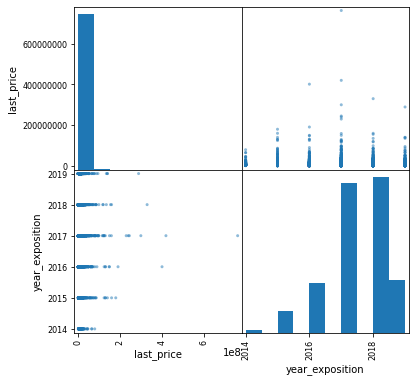

In [157]:
pd.plotting.scatter_matrix(data[['last_price', 'year_exposition']], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['year_exposition']))

Корреляция между ценой и значениями года отсутствует

 #### Влияние категории этажа объекта на цену

поскольку матрица корреляции не может быть построена с категориальными данным, совершим преобразование

In [158]:
transform_cat_num = pd.Series([0,1,2], index=['первый','другой','последний'])    
data['transform']=data.floor_category.map(transform_cat_num)

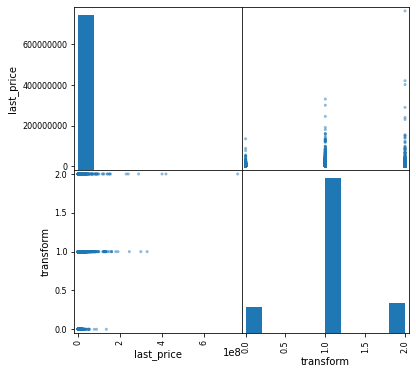

In [159]:
pd.plotting.scatter_matrix(data[['last_price','transform']], figsize=(6,6));

In [160]:
data = data.drop('transform', axis=1)

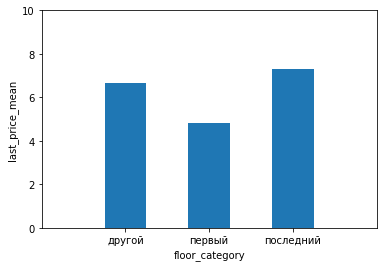

In [161]:
i,j,k,l = ['floor_category', 'last_price', 3, 10]
data_t = data.pivot_table(index=i, values=j, aggfunc='mean')
plt.bar(data_t.index, data_t['last_price']/1000000, 0.5)
plt.xlabel(i)
plt.ylabel(j+'_mean')
plt.axis([-1, k, 0, l])
plt.show()

Можно сделать вывод, что первые этажы как правило дешевле

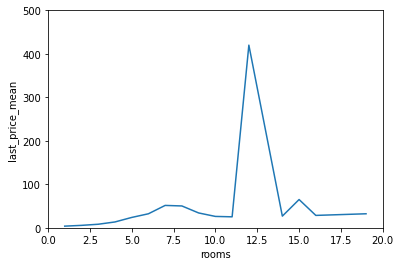

In [162]:
i,j,k,l = ['rooms', 'last_price', 20, 500]
data_t = data.pivot_table(index=i, values=j, aggfunc='mean')
plt.plot(data_t.index, data_t['last_price']/1000000)
plt.xlabel(i)
plt.ylabel(j+'_mean')
plt.axis([0, k, 0, l])
plt.show()

С увеличением количества комнат цена растет

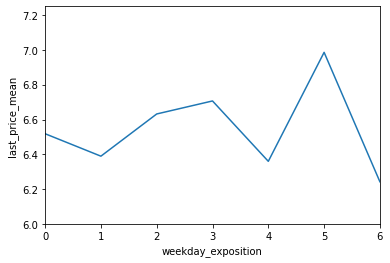

In [163]:
i,j,k,l = ['weekday_exposition', 'last_price', 6, 7.25]
data_t = data.pivot_table(index=i, values=j, aggfunc='mean')
plt.plot(data_t.index, data_t['last_price']/1000000)
plt.xlabel(i)
plt.ylabel(j+'_mean')
plt.axis([0, k, 6, l])
plt.show()

В субботу средняя цена на квартиры выше, а в воскресенье ниже всего

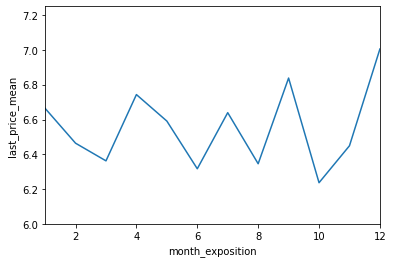

In [164]:
i,j,k,l = ['month_exposition', 'last_price', 12, 7.25]
data_t = data.pivot_table(index=i, values=j, aggfunc='mean')
plt.plot(data_t.index, data_t['last_price']/1000000)
plt.xlabel(i)
plt.ylabel(j+'_mean')
plt.axis([1, k, 6, l])
plt.show()

В октябре средняя цена на квартиры ниже, а в декабре выше всего

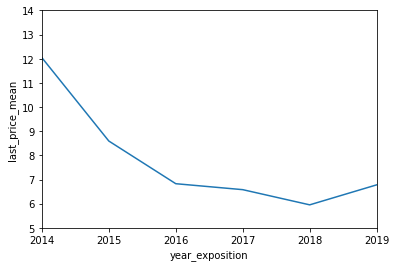

In [165]:
i,j,k,l = ['year_exposition', 'last_price', 2019, 14]
data_t = data.pivot_table(index=i, values=j, aggfunc='mean')
plt.plot(data_t.index, data_t['last_price']/1000000)
plt.xlabel(i)
plt.ylabel(j+'_mean')
plt.axis([2014, k, 5, l])
plt.show()

C 2014 года средняя цена на объект упала в 2 раза

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №2__

Отличный инсайд для заказчика. Молодец =)

### Средняя ценa кв.м в 10 населённых пунктах с наибольшим числом объявлений

In [166]:
data.pivot_table(
    index='locality_name', values='price_per_sq_m', aggfunc=['count','median'])\
.sort_values(('count','price_per_sq_m'), ascending=False).iloc[:10]\
.style.format({('median','price_per_sq_m'): "{:,.0f}"})

,count,median
,price_per_sq_m,price_per_sq_m
locality_name,,
Санкт-Петербург,15650,"104,782"
Мурино,586,"86,250"
Кудрово,470,"95,555"
Шушары,439,"76,829"
Всеволожск,398,"65,789"
Пушкин,369,"100,000"
Колпино,338,"74,724"
Парголово,327,"91,643"


### Средняя стоимость объекта в Санкт-Петербурге на разном удалении от центра

In [167]:
data_SP = data.query('locality_name == "Санкт-Петербург"')\
.pivot_table(index='city_centre_distance_km', values='last_price', aggfunc='mean')
data_SP.style.format({"last_price" : "{:,.0f}"})

,last_price
city_centre_distance_km,
0.0,"31,449,116"
1.0,"21,206,721"
2.0,"17,788,320"
3.0,"11,137,395"
4.0,"13,304,280"
5.0,"14,455,996"
6.0,"15,338,418"
7.0,"14,775,153"
8.0,"10,189,037"


построим матрицу корреляции для цены и удаленности объекта от центра города

PearsonRResult(statistic=-0.2133940916971229, pvalue=8.471956852427389e-241)


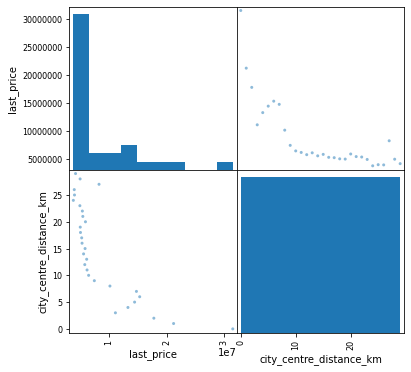

In [168]:
pd.plotting.scatter_matrix(data_SP.reset_index()\
                           [['last_price', 'city_centre_distance_km']], figsize=(6,6));
print(stats.pearsonr(data['last_price'], data['city_centre_distance_km']))

На графике видна умеренная обратня корреляционная зависимость.
Средняя цена квартиры падает в зависимости, чем дальше она от центра города.

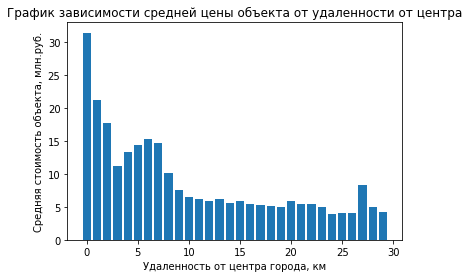

In [169]:
plt.bar(data_SP.index, data_SP['last_price']/1000000)
plt.xlabel('Удаленность от центра города, км')
plt.ylabel('Средняя стоимость объекта, млн.руб.')
plt.title('График зависимости средней цены объекта от удаленности от центра')
plt.show()

In [170]:
# выделим в отдельный df значения с Санкт-Петербургом
data_SP = data[data['locality_name'] == "Санкт-Петербург"].reset_index()

# разобъем массив в зависимости от удаленности от центра на три категории
data_SP['cityCentres_cat'] = pd.cut(data_SP['cityCenters_nearest'],
                                    3, precision=0,
                                    labels=['близко от центра',
                                            'средне от центра',
                                            'далеко от центра'])

# посчитаем средние значения стоимости объекта в зависимости от удаленности от центра
data_SP.pivot_table(
    index='cityCentres_cat',
    values='last_price',
    aggfunc=['mean']).style.format({('mean','last_price'): "{:,.0f}"})

,mean
,last_price
cityCentres_cat,
близко от центра,"12,877,771"
средне от центра,"5,810,077"
далеко от центра,"5,170,848"


## Общий вывод

Проведен анализ данных  сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

**Данные содержат:**
- 23 699 строк
- 22 колонки
- 17 цифоровых
- 3 строковых
- 2 булевых
- колонки 0-4 и 8,10,11 не содержат пропусков

### Выводы по предобработке данных

Выполнена следующая предобработка данных:
1.	`total_images` — число фотографий квартиры в объявлении
<br> оставлена без изменений

2.	`last_price` — цена на момент снятия с публикации
<br> колонка не содержит пропусков, однако есть 2х комнатная квартира общей площадью 109 кв.м, при этом жилая 32 кв.м и стоит всего 12 тыс.рублей.  Эта строку удалили, поскольку ошибка и в цене и в площади и интерпретировать эти данные не возможно. 
3.	`total_area` — общая площадь квартиры в квадратных метрах (м²)
<br> колонка не содержит пропусков, оставлена без изменений.

4.	`first_day_exposition` — дата публикации
<br> колонка не содержит пропусков, но данные в представлены в строковом виде (object). Данные переведены в тип  (datetime).
    
5.	`rooms` — число комнат
<br> колонка не содержит пропусков, однако 197 объектов имеет 0 комнат. Причиной ошибки скорее всего стал человеческий фактор и владельцы просто не внесли эти данные. Данные заполнили средними значение из группы объектов с похожими значениями общей площади.
Создали новую колонку и распределили данные на группы по размерам общей площади:
- до 25 кв.м (G)
- 26 - 45 кв.м (F)
- 46 - 65 кв.м (E)
- 66 - 105 кв.м (D)
- 106 - 205 кв.м (C)
- 206 - 305 кв.м (B)
- более 306 кв.м (A)
Для каждой группы определили медианное значение количества комнат.  0 комнат заменили на соответствующее медианное значение из группы. Привели данные к целочисленному виду.  
    
6.	`ceiling_height` — высота потолков (м)
<br> Из 23699 строк данных только 14504 (чуть больше половины) содержат информацию о высоте потолка. Колонка содержит подозрительные данные с высотой потолков более 5 и менее 2,4 метров. Сначала обработали данные с аномально высокими потолками. Так как большие дорогие квартиры могут иметь потолки и выше 5 метров, то мы ограничем размеры выборки общей плщощадью менее 100 кв.м. 32 строки содержат явные ошибки в высоте потолков. Скорее всего ошибки возникли из-за разницы размерности высоты: кто-то вносил в метрах, кто-то в сантиметрах. Поскольку данных о высоте потолков и так мало, попробуем не удалять, а внести исправления. Заменили подозрительные данные на значения NaN.
Затем оценили минимальную высоту потолков.
По СанПину высота потолков в квартире должна быть не менее 2,5 метров. С учетом наличия современных подвесных потолков, примем за отсечку в 2,4 метра. 21 строки содержат подозрительно низкие высоты потолков. Скорее всего ошибки возникли из-за также из-за разницы размерности высоты: кто-то вносил в метрах, кто-то в сантиметрах. Поскольку данных о высоте потолков и так мало, попробуем не удалять, а внести исправления. Также заменили подозрительные данные на значения NaN.
Существующие и получившиеся пропуски заменили на средние значениями высоты потолков из объектов той же категории общей площади.

7.	`floors_total` — всего этажей в доме
<br> Количество данных с пропуском этажности дома - 86. Общая этажность дома влияет на стоимость квартиры. Но т.к. эти данные невозможно экстраполировать из других категорий, то придется пожертвовать 86 строками. Привели данные к целочисленному виду.

8.	`living_area` — жилая площадь в квадратных метрах (м²)
Количество данных с пропусками в жилой площади дома - 1870. В данных есть 4 квартиры в разных категориях с подозрительно низкими значениями жилой площади (менее < 5 кв.м). Возможно ошибки возникли в результате того, что пользователи неправильные вычесления, поскольку жилая площадь - это площадь без учета балконов, коридоров, сан.узлов и кухни, и  поэтому разница получилась ошибочно малой. Удалили данные c жилой площадью менее 5 кв.м. заменив на NaN. Поскольку жилая площадь является уменьшенной общей площадью на определенный коэффициент, то ввели данный коэффициент для каждой категории квартир. Создали вспомогательный столбец (k) отношение жилой к общей площади и заполнили средним значением для объектов той же категории. Пропуски жилой площади заполнили значением полученным делением жилой площади на k отношения жилой площади к общей.

9.	`floor` — этаж
<br> колонка не содержит пропусков. Привели данные к целочисленному виду. 

10.	`is_apartment` — апартаменты (булев тип)
<br> Колонка содержит 20924 пропуска. Поскольку апартаменты встречаются гораздо реже, то заменили значения NaN на False.

11.	`studio` — квартирастудия (булев тип)
<br> колонка не содержит пропусков, оставлена без изменений.

12.	`open_plan` — свободная планировка (булев тип)
<br> колонка не содержит пропусков, оставлена без изменений.

13.	`kitchen_area` — площадь кухни в квадратных метрах (м²)
<br> Колонка содержит 2231 пропуска. Согласно СанПин нормам минимальная площадь кухни-купе может быть 5 кв.м. В данных есть 104 строки с площадью менее 5 кв.м. Возможно ошибки возникли в результате того, что пользователи вместо площади указали ширину кухни. Заполнили ошибки тем же способом, что и жилую площадь. Заменили ошибочные данные с площадью кухни на NaN, ввели коэффициент отношения общей площади к площади кухни, заполнли значения NaN результатом деления общей площади на коэффициент.

14.	`balcony` — число балконов
<br> Колонка содержит около поливины пропусков. Заменили отсутствующие данные на 0. Заменили категорию данных (float) на (int), поскольку число балковнов может быть только целым. Квартиры с числом болканов больше 2 выглядят подозрительно. Если в квартире не более 2ух комнат, наличие 4 балконов и более - явная ошибка, кухня и две комнаты дают возможность только для 3 балконов. Возможно ошибки вызваны, тем что пользователи заполнили площадь балкона, вместо их количества. Заменили в квартирах общей площадью менее 100 кв.м с количеством комнат 2 и менее число балконов с 3 и более на 1.

15.	`locality_name` — название населённого пункта
<br> Колонка содержит 48 пропусков, так как данные о населенном пункте невозможно экстраполировать, то эти данные придется удалить. Колонка содержит 364 уникальных наименования. Названия приведены к единообразию: удалили из названия тип поселения и заменили буквы ё на е. После преобразований количество уникальных значений уменьшилось на 59 до 305.  

16.	`airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
<br> Колонка содержит 48 пропусков. Одна строка содержала расстояние 0 м и была заменена NaN. Пропуски могли образовиться из-за ошибок в геосервисах. Пропушенные данные были заполнены средним расстоянием до аэропорта.

17.	`cityCenters_nearest` — расстояние до центра города (м)
<br> Колонка содержит 5501 пропуск. Заполнили пропуски средними значениями расстояния до центра города в зависимости от категории квартиры.

18.	`parks_around3000` — число парков в радиусе 3 км
<br> Колонка содержит 5500 пропуск. Заполнили пропуски самым частым значением в колонке - 0. Изменили категорию данных с float на int, поскольку количество парков может быть только целым. 

19.	`parks_nearest` — расстояние до ближайшего парка (м)
<br> Колонка содержит 15535 пропусков. Заполним пропуски средним расстоянием парков за пределами 3 км зоны досягаемости.

20.	`ponds_around3000` — число водоёмов в радиусе 3 км
<br> Колонка содержит 5500 пропусков. Заполнили пропуски самым частым значением в колонке - 0. Изменили категорию данных с float на int, поскольку количество водоемов может быть только целым.
Проверили нет ли объектов, у которых расстояние до воды менее 3 км, но не проставлено количество водоемов в зоне досягаемости. 4249 объекта с расстоянием менее 3 км до водоема не имели значение в колонке количетво водоемов. Исправили данные в колоноке ponds_nearest заменив 0 на хотя бы 1 водоем, если досягаемость менее или равна 3000 м.

21.	`ponds_nearest` — расстояние до ближайшего водоёма (м)
<br> Колонка содержит 14528 пропусков. Т.к. у нас нет данных об объектах за пределами 3 км зоны, то заполнили отсутствующие значение любым расстоянием большим 3 км (взяли цифру в 5000 м).

22.	`days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
<br> Колонка содержит 14528 пропусков. Пропуски означают, что квартира еще продается. Определили дату загрузки данных - 2019-05-03, посчитали разницу между этим днем и первым днем экспозиции. Заполнили разницей пропущенные значения. Привели длительность экспозиции к целочисленному типу (int).

- проверили пропуски - пропуски отсутствуют
- удалили вспомогательные колоноки
- оценили количество удаленных данных: eдалено 135 строк (0.6 % от изначальных данных)


### Добавили новые столбцы

- `price_per_sq_m` - цена одного квадратного метра (значение до двух знаков после запятой)
- `weekday_exposition` - день недели публикации
- `month_exposition` - месяц публикации
- `year_exposition` - год публикации
- `floor_category` - категория этажа
- `city_centre_distance_km` - расстояние до центра в км

### Анализ данных

#### Параметры

1.	`total_area` — общая площадь квартиры в квадратных метрах (м²)
- Общая площадь количество уникальных 2159
- Общая площадь максимальное значение 900
- Общая площадь минимальное значение 12
- Общая площадь среднее значение 60
- Общая площадь самое частое значение 45
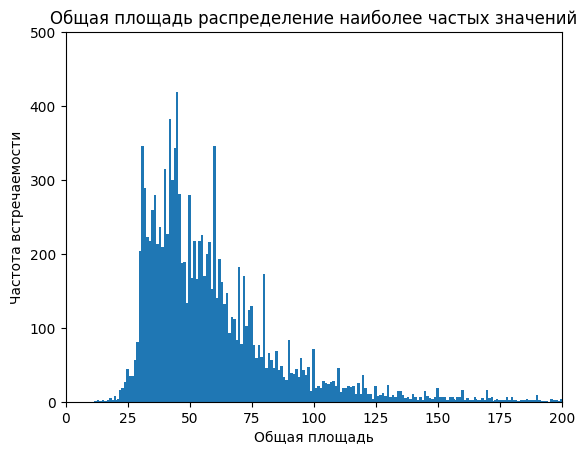
2.	`living_area` — жилая площадь в квадратных метрах (м²)
- Количество уникальных значений 1816
- Жилая площадь максимальное значение 410
- Жилая площадь минимальное значение 5
- Жилая площадь среднее значение 35
- Жилая площадь самое частое значение 18
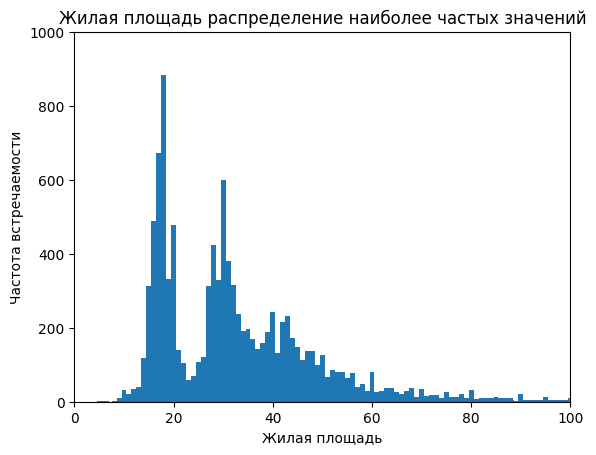
3.	`kitchen_area` — площадь кухни в квадратных метрах (м²)
- Количество уникальных значений 956
- Площадь кухни максимальное значение 112
- Площадь кухни минимальное значение 3
- Площадь кухни среднее значение 10
- Площадь кухни самое частое значение 6
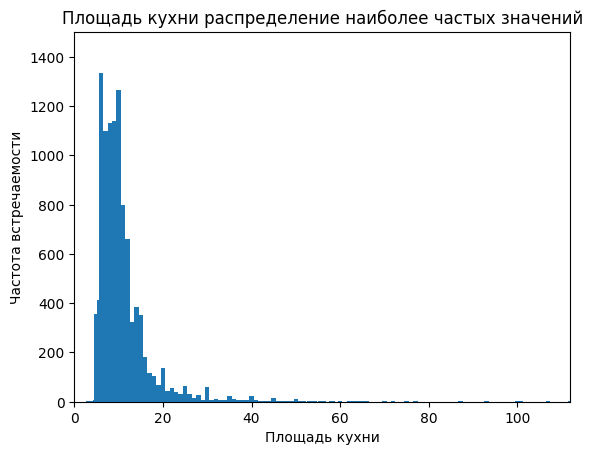
4.	`rooms` — число комнат
- Количество уникальных значений 16
- Количество комнат максимальное значение 19
- Количество комнат минимальное значение 1
- Количество комнат среднее значение 2
- Количество комнат самое частое значение 1
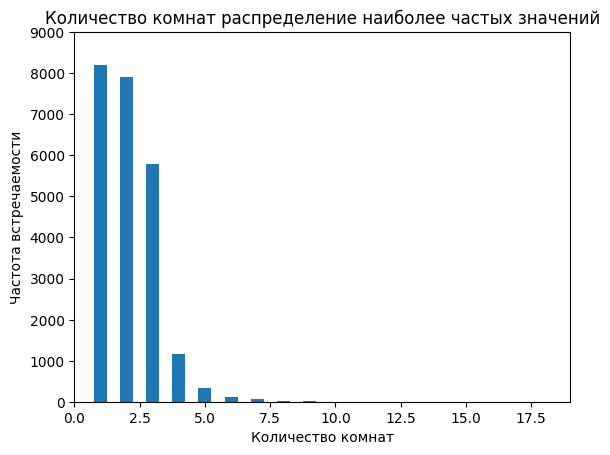
6.	`ceiling_height` — высота потолков (м)
- Количество уникальных значений 160
- Высота потолков максимальное значение 6.0
- Высота потолков минимальное значение 2.4
- Высота потолков среднее значение 2.7
- Высота потолков самое частое значение 2.6
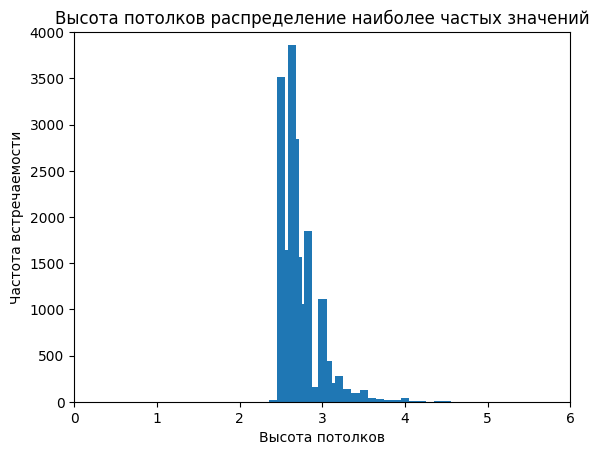
6.	`floors_total` — всего этажей в доме
- Количество уникальных значений 36
- Общее количество этажей максимальное значение 60
- Общее количество этажей минимальное значение 1
- Общее количество этажей среднее значение 11
- Общее количество этажей самое частое значение 5
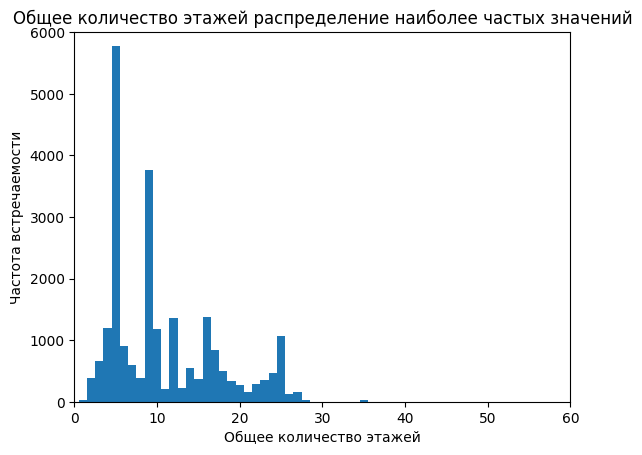
7.	`cityCenters_nearest` — расстояние до центра города (м)
- Количество уникальных значений 7627
- Расстояние до центра города максимальное значение 65968
- Расстояние до центра города минимальное значение 181
- Расстояние до центра города среднее значение 14363
- Расстояние до центра города самое частое значение 15957
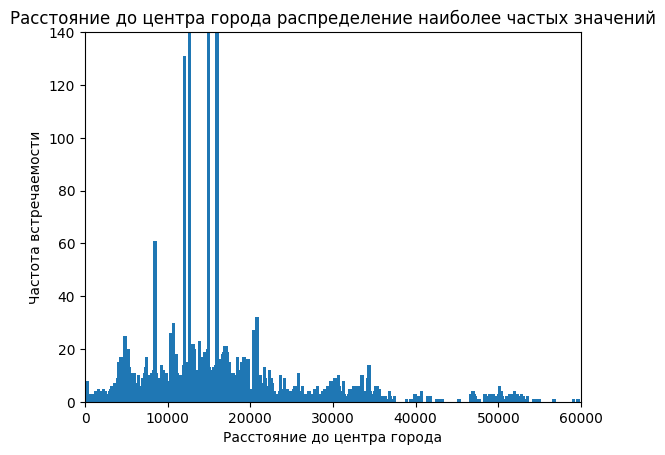
8.	`parks_nearest` — расстояние до ближайшего парка (м)
- Количество уникальных значений 995
- Расстояние до ближайшего парка максимальное значение 3190
- Расстояние до ближайшего парка минимальное значение 1
- Расстояние до ближайшего парка среднее значение 2220
- Расстояние до ближайшего парка самое частое значение 3114
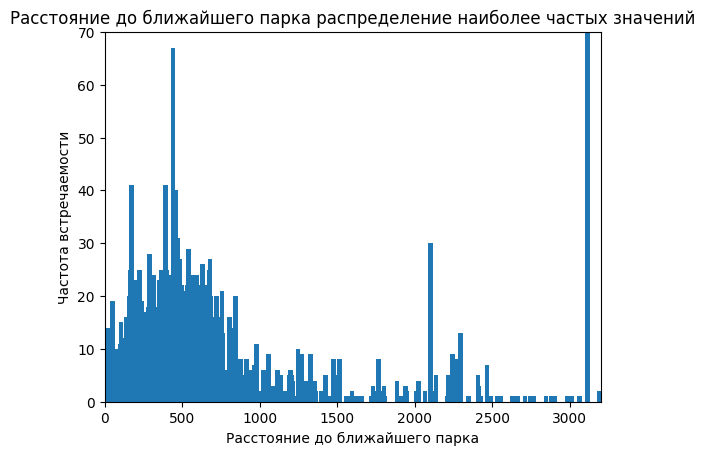
9.	`floor_category` - категория этажа
- Количество объектов на первом этаже: 2884
- Количество объектов на последнем этаже: 3354
- Количество объектов ни на первом, ни на последнем этаже: 17326

10.	`last_price` — цена на момент снятия с публикации
- Количество уникальных значений 2924
- Цена объекта максимальное значение 763000000
- Цена объекта минимальное значение 430000
- Цена объекта среднее значение 6540335
- Цена объекта самое частое значение 4500000
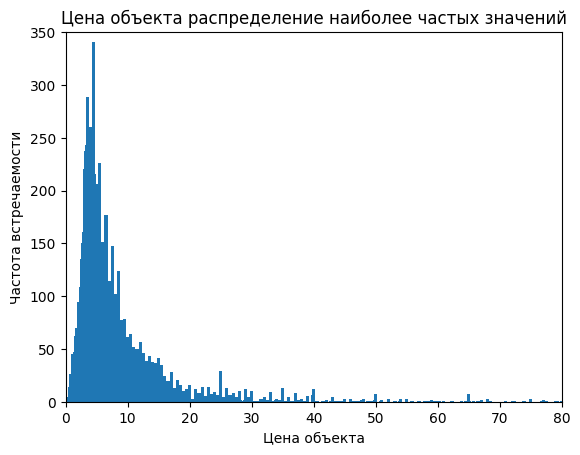

#### Как быстро продовались квартиры

##### График сроков продажи

Выделили данные без 0 дней, т.е. те квартиры, которые уже продались.
Построили гистограмму дней продажи.
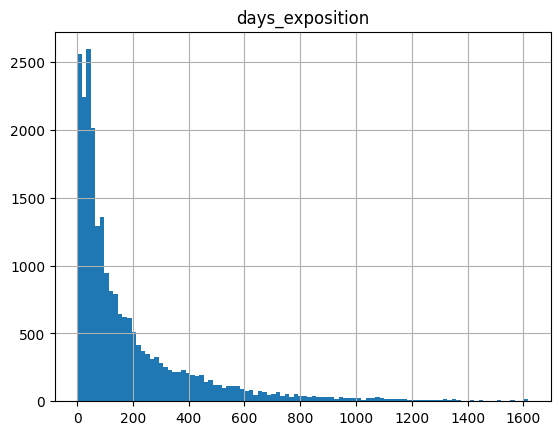
Построили график наиболее частых сроков продажи
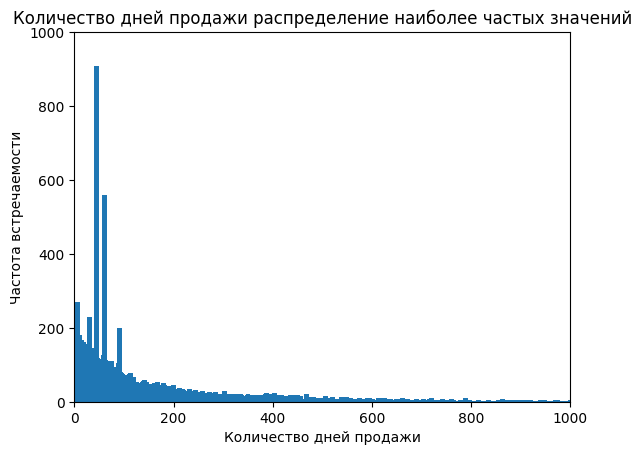

##### Средние сроки продажи

- Среднее значение дней продажи - 186 дней
- Медиана значений сроков продаж - 94 дня <br>
Поскольку у нас смещенное распределение, то для оценки среднего значения лучше взять медиану.
Однако, медиана не полностью отражает ориентировочный срок продажи. Для более наглядного представления возьмем межквартильный размах.

- Первый квартиль 43 дня
- Третий квартиль 237 дня
- Количество значений в IQR 11692
- Процент значений в IQR 50%


##### Аномальные сроки продажи

Аномальными значениями дней продаж (слишком быстрыми, либо долгими) будем считать значения за пределами доверительного интервала 0.95
- Необчно быстрые продажи менее 5 дней
- Необчно долгие продажи более 884 дней

 #### Факторы влияющие на общую стоимость объекта

##### Влияние общей площади объекта на цену

Построили матрицу корреляции 
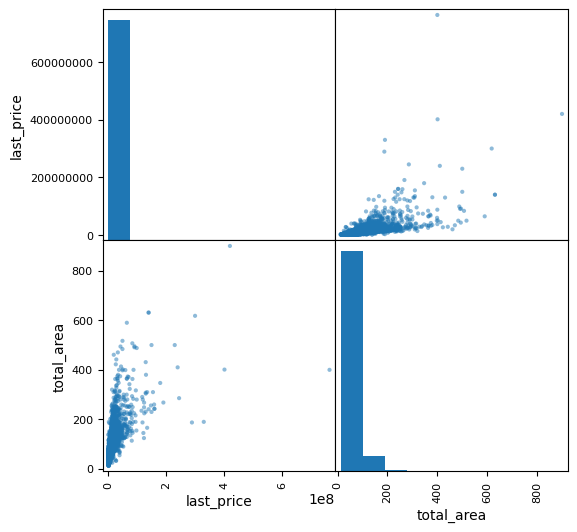
Коэффициент Пирсона = 0,65

Умеренная прямая корреляцию между ценой объекта значениями площадей и количеством комнат объекта.

##### Влияние жилой площади объекта на цену

Построили матрицу корреляции 
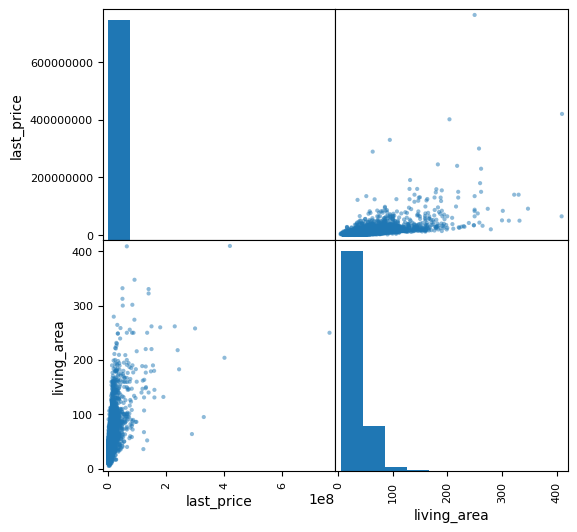
Коэффициент Пирсона = 0,59

Умеренная прямая корреляцию между ценой объекта значениями площадей и количеством комнат объекта.

##### Влияние  площади кухни объекта на цену

Построили матрицу корреляции 
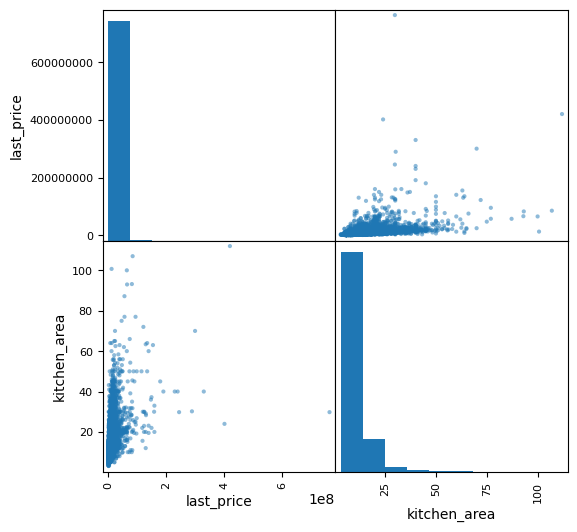
Коэффициент Пирсона = 0,48

Умеренная прямая корреляцию между ценой объекта значениями площадей и количеством комнат объекта.

##### Влияние значений деня недели на цену объекта
Построили график  для средней цены и значений дня недели выставления на продажу.
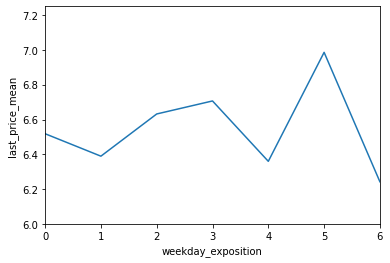
В субботу средняя цена на квартиры выше, а в воскресенье ниже всего

##### Влияние значений месяца на цену объекта
Построили график  для средней цены и значений месяца выставления на продажу.
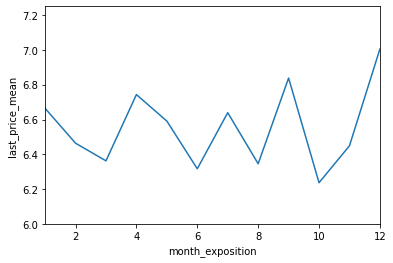
В октябре средняя цена на квартиры ниже, а в декабре ниже всего

##### Влияние значений года  на цену объекта
Построили график  для средней цены и значений года выставления на продажу.
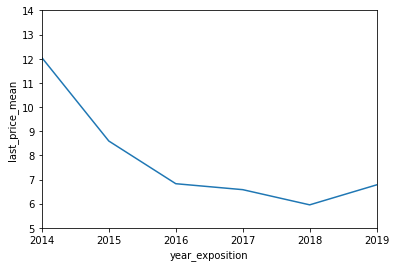
C 2014 года средняя цена на объект упала в 2 раза

##### Влияние категории этажа объекта на цену

Построили график распределения средней цены объекта в зависимости от категории этажа.
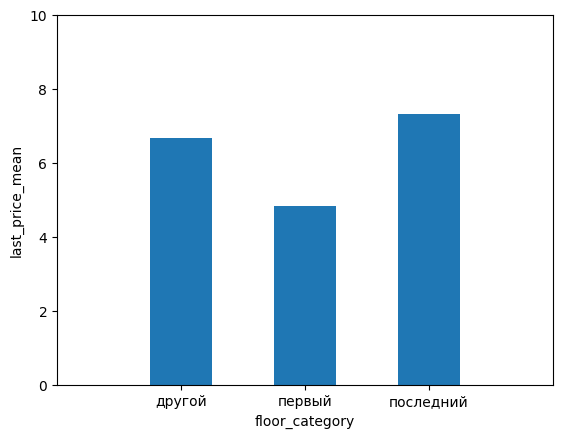
Самая высокая средняя цена у категории 'последний' самая дешевая - 'первый'

#### Средняя ценa кв.м в 10 населённых пунктах с наибольшим числом объявлений

<style type="text/css">
</style>
<table id="T_2d6f2">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_2d6f2_level0_col0" class="col_heading level0 col0" >count</th>
      <th id="T_2d6f2_level0_col1" class="col_heading level0 col1" >mean</th>
    </tr>
    <tr>
      <th class="blank level1" >&nbsp;</th>
      <th id="T_2d6f2_level1_col0" class="col_heading level1 col0" >price_per_sq_m</th>
      <th id="T_2d6f2_level1_col1" class="col_heading level1 col1" >price_per_sq_m</th>
    </tr>
    <tr>
      <th class="index_name level0" >locality_name</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_2d6f2_level0_row0" class="row_heading level0 row0" >Санкт-Петербург</th>
      <td id="T_2d6f2_row0_col0" class="data row0 col0" >15650</td>
      <td id="T_2d6f2_row0_col1" class="data row0 col1" >114,876</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row1" class="row_heading level0 row1" >Мурино</th>
      <td id="T_2d6f2_row1_col0" class="data row1 col0" >586</td>
      <td id="T_2d6f2_row1_col1" class="data row1 col1" >86,041</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row2" class="row_heading level0 row2" >Кудрово</th>
      <td id="T_2d6f2_row2_col0" class="data row2 col0" >470</td>
      <td id="T_2d6f2_row2_col1" class="data row2 col1" >95,261</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row3" class="row_heading level0 row3" >Шушары</th>
      <td id="T_2d6f2_row3_col0" class="data row3 col0" >439</td>
      <td id="T_2d6f2_row3_col1" class="data row3 col1" >78,551</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row4" class="row_heading level0 row4" >Всеволожск</th>
      <td id="T_2d6f2_row4_col0" class="data row4 col0" >398</td>
      <td id="T_2d6f2_row4_col1" class="data row4 col1" >68,654</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row5" class="row_heading level0 row5" >Пушкин</th>
      <td id="T_2d6f2_row5_col0" class="data row5 col0" >369</td>
      <td id="T_2d6f2_row5_col1" class="data row5 col1" >103,126</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row6" class="row_heading level0 row6" >Колпино</th>
      <td id="T_2d6f2_row6_col0" class="data row6 col0" >338</td>
      <td id="T_2d6f2_row6_col1" class="data row6 col1" >75,425</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row7" class="row_heading level0 row7" >Парголово</th>
      <td id="T_2d6f2_row7_col0" class="data row7 col0" >327</td>
      <td id="T_2d6f2_row7_col1" class="data row7 col1" >90,176</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row8" class="row_heading level0 row8" >Гатчина</th>
      <td id="T_2d6f2_row8_col0" class="data row8 col0" >307</td>
      <td id="T_2d6f2_row8_col1" class="data row8 col1" >68,746</td>
    </tr>
    <tr>
      <th id="T_2d6f2_level0_row9" class="row_heading level0 row9" >Выборг</th>
      <td id="T_2d6f2_row9_col0" class="data row9 col0" >237</td>
      <td id="T_2d6f2_row9_col1" class="data row9 col1" >58,142</td>
    </tr>
  </tbody>
</table>


#### Средняя стоимость объекта в Санкт-Петербурге на разном удалении от центра

<style type="text/css">
</style>
<table id="T_5955c">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_5955c_level0_col0" class="col_heading level0 col0" >last_price</th>
    </tr>
    <tr>
      <th class="index_name level0" >city_centre_distance_km</th>
      <th class="blank col0" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_5955c_level0_row0" class="row_heading level0 row0" >0.000000</th>
      <td id="T_5955c_row0_col0" class="data row0 col0" >31,449,116</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row1" class="row_heading level0 row1" >1.000000</th>
      <td id="T_5955c_row1_col0" class="data row1 col0" >21,206,721</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row2" class="row_heading level0 row2" >2.000000</th>
      <td id="T_5955c_row2_col0" class="data row2 col0" >17,788,320</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row3" class="row_heading level0 row3" >3.000000</th>
      <td id="T_5955c_row3_col0" class="data row3 col0" >11,137,395</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row4" class="row_heading level0 row4" >4.000000</th>
      <td id="T_5955c_row4_col0" class="data row4 col0" >13,304,280</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row5" class="row_heading level0 row5" >5.000000</th>
      <td id="T_5955c_row5_col0" class="data row5 col0" >14,455,996</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row6" class="row_heading level0 row6" >6.000000</th>
      <td id="T_5955c_row6_col0" class="data row6 col0" >15,327,972</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row7" class="row_heading level0 row7" >7.000000</th>
      <td id="T_5955c_row7_col0" class="data row7 col0" >14,775,153</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row8" class="row_heading level0 row8" >8.000000</th>
      <td id="T_5955c_row8_col0" class="data row8 col0" >10,189,037</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row9" class="row_heading level0 row9" >9.000000</th>
      <td id="T_5955c_row9_col0" class="data row9 col0" >7,486,057</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row10" class="row_heading level0 row10" >10.000000</th>
      <td id="T_5955c_row10_col0" class="data row10 col0" >6,500,434</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row11" class="row_heading level0 row11" >11.000000</th>
      <td id="T_5955c_row11_col0" class="data row11 col0" >6,228,108</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row12" class="row_heading level0 row12" >12.000000</th>
      <td id="T_5955c_row12_col0" class="data row12 col0" >5,561,185</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row13" class="row_heading level0 row13" >13.000000</th>
      <td id="T_5955c_row13_col0" class="data row13 col0" >5,582,452</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row14" class="row_heading level0 row14" >14.000000</th>
      <td id="T_5955c_row14_col0" class="data row14 col0" >5,625,173</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row15" class="row_heading level0 row15" >15.000000</th>
      <td id="T_5955c_row15_col0" class="data row15 col0" >4,356,174</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row16" class="row_heading level0 row16" >16.000000</th>
      <td id="T_5955c_row16_col0" class="data row16 col0" >3,378,337</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row17" class="row_heading level0 row17" >17.000000</th>
      <td id="T_5955c_row17_col0" class="data row17 col0" >5,272,066</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row18" class="row_heading level0 row18" >18.000000</th>
      <td id="T_5955c_row18_col0" class="data row18 col0" >4,863,229</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row19" class="row_heading level0 row19" >19.000000</th>
      <td id="T_5955c_row19_col0" class="data row19 col0" >4,626,779</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row20" class="row_heading level0 row20" >20.000000</th>
      <td id="T_5955c_row20_col0" class="data row20 col0" >5,176,527</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row21" class="row_heading level0 row21" >21.000000</th>
      <td id="T_5955c_row21_col0" class="data row21 col0" >4,973,884</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row22" class="row_heading level0 row22" >22.000000</th>
      <td id="T_5955c_row22_col0" class="data row22 col0" >5,276,427</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row23" class="row_heading level0 row23" >23.000000</th>
      <td id="T_5955c_row23_col0" class="data row23 col0" >4,796,776</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row24" class="row_heading level0 row24" >24.000000</th>
      <td id="T_5955c_row24_col0" class="data row24 col0" >4,227,010</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row25" class="row_heading level0 row25" >25.000000</th>
      <td id="T_5955c_row25_col0" class="data row25 col0" >4,725,755</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row26" class="row_heading level0 row26" >26.000000</th>
      <td id="T_5955c_row26_col0" class="data row26 col0" >5,169,887</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row27" class="row_heading level0 row27" >27.000000</th>
      <td id="T_5955c_row27_col0" class="data row27 col0" >5,946,410</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row28" class="row_heading level0 row28" >28.000000</th>
      <td id="T_5955c_row28_col0" class="data row28 col0" >4,778,821</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row29" class="row_heading level0 row29" >29.000000</th>
      <td id="T_5955c_row29_col0" class="data row29 col0" >4,663,843</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row30" class="row_heading level0 row30" >30.000000</th>
      <td id="T_5955c_row30_col0" class="data row30 col0" >4,418,249</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row31" class="row_heading level0 row31" >31.000000</th>
      <td id="T_5955c_row31_col0" class="data row31 col0" >4,736,144</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row32" class="row_heading level0 row32" >32.000000</th>
      <td id="T_5955c_row32_col0" class="data row32 col0" >4,290,659</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row33" class="row_heading level0 row33" >33.000000</th>
      <td id="T_5955c_row33_col0" class="data row33 col0" >4,436,332</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row34" class="row_heading level0 row34" >34.000000</th>
      <td id="T_5955c_row34_col0" class="data row34 col0" >5,421,772</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row35" class="row_heading level0 row35" >35.000000</th>
      <td id="T_5955c_row35_col0" class="data row35 col0" >5,851,949</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row36" class="row_heading level0 row36" >36.000000</th>
      <td id="T_5955c_row36_col0" class="data row36 col0" >5,121,822</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row37" class="row_heading level0 row37" >37.000000</th>
      <td id="T_5955c_row37_col0" class="data row37 col0" >4,086,154</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row38" class="row_heading level0 row38" >39.000000</th>
      <td id="T_5955c_row38_col0" class="data row38 col0" >3,100,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row39" class="row_heading level0 row39" >40.000000</th>
      <td id="T_5955c_row39_col0" class="data row39 col0" >4,325,562</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row40" class="row_heading level0 row40" >41.000000</th>
      <td id="T_5955c_row40_col0" class="data row40 col0" >3,494,333</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row41" class="row_heading level0 row41" >42.000000</th>
      <td id="T_5955c_row41_col0" class="data row41 col0" >3,058,333</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row42" class="row_heading level0 row42" >43.000000</th>
      <td id="T_5955c_row42_col0" class="data row42 col0" >11,531,483</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row43" class="row_heading level0 row43" >45.000000</th>
      <td id="T_5955c_row43_col0" class="data row43 col0" >5,100,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row44" class="row_heading level0 row44" >47.000000</th>
      <td id="T_5955c_row44_col0" class="data row44 col0" >3,908,714</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row45" class="row_heading level0 row45" >48.000000</th>
      <td id="T_5955c_row45_col0" class="data row45 col0" >5,181,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row46" class="row_heading level0 row46" >49.000000</th>
      <td id="T_5955c_row46_col0" class="data row46 col0" >4,315,519</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row47" class="row_heading level0 row47" >50.000000</th>
      <td id="T_5955c_row47_col0" class="data row47 col0" >3,722,673</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row48" class="row_heading level0 row48" >51.000000</th>
      <td id="T_5955c_row48_col0" class="data row48 col0" >4,890,952</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row49" class="row_heading level0 row49" >52.000000</th>
      <td id="T_5955c_row49_col0" class="data row49 col0" >3,462,679</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row50" class="row_heading level0 row50" >53.000000</th>
      <td id="T_5955c_row50_col0" class="data row50 col0" >4,258,571</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row51" class="row_heading level0 row51" >54.000000</th>
      <td id="T_5955c_row51_col0" class="data row51 col0" >6,273,150</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row52" class="row_heading level0 row52" >55.000000</th>
      <td id="T_5955c_row52_col0" class="data row52 col0" >9,000,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row53" class="row_heading level0 row53" >57.000000</th>
      <td id="T_5955c_row53_col0" class="data row53 col0" >3,015,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row54" class="row_heading level0 row54" >59.000000</th>
      <td id="T_5955c_row54_col0" class="data row54 col0" >4,250,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row55" class="row_heading level0 row55" >60.000000</th>
      <td id="T_5955c_row55_col0" class="data row55 col0" >2,050,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row56" class="row_heading level0 row56" >61.000000</th>
      <td id="T_5955c_row56_col0" class="data row56 col0" >3,200,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row57" class="row_heading level0 row57" >62.000000</th>
      <td id="T_5955c_row57_col0" class="data row57 col0" >3,200,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row58" class="row_heading level0 row58" >63.000000</th>
      <td id="T_5955c_row58_col0" class="data row58 col0" >3,600,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row59" class="row_heading level0 row59" >65.000000</th>
      <td id="T_5955c_row59_col0" class="data row59 col0" >3,475,000</td>
    </tr>
    <tr>
      <th id="T_5955c_level0_row60" class="row_heading level0 row60" >66.000000</th>
      <td id="T_5955c_row60_col0" class="data row60 col0" >3,933,333</td>
    </tr>
  </tbody>
</table>

Построили матрицу корреляции и график для цены и удаленности объекта от центра города.
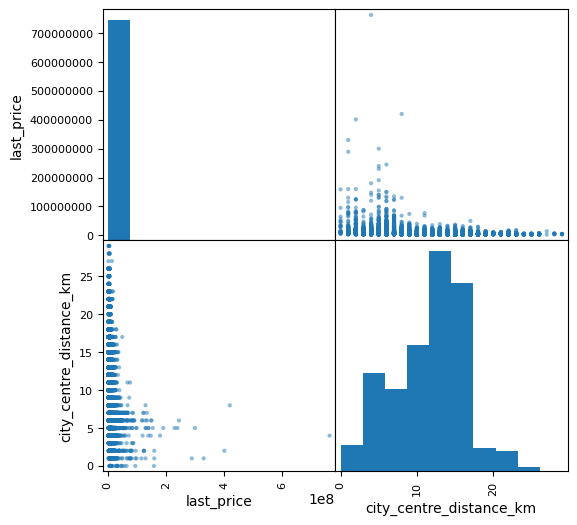
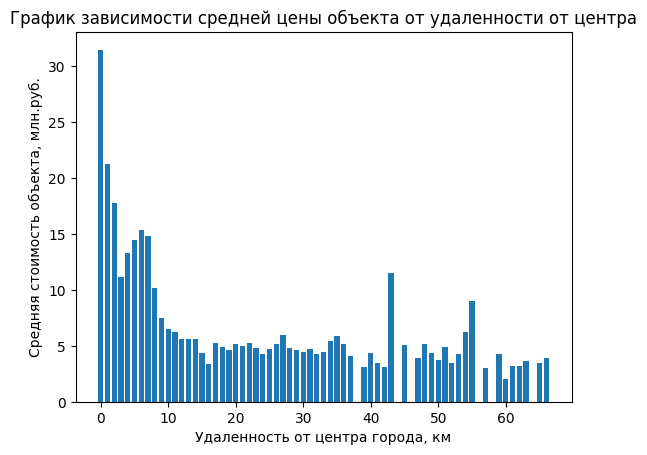

На графике видна умеренная обратня корреляционная зависимость.
Средняя цена квартиры падает при удалении от центра города.